In [1]:
import importlib
import net
importlib.reload(net)
from net import *
from copy import deepcopy

## 1. Single Network: Open and Closed Loop Runs

In [89]:
net = IzhikevichNetwork(80, 20, 10, 10, seed=14, noise_std = 5.0, A_LTP=1.0, 
                        A_LTD=1.1, tau_LTP=20.0, tau_LTD=24.0)

### 1.1 Open and Closed Loop Function Definitions

In [2]:
# same frequency and structure as closed-loop; on and off times are broadly distributed
def run_periodic_open_loop(net: IzhikevichNetwork, T: float, K: float = 2.0, freq=20.0,
                           amp=10.0, on_range=(500, 1000), off_range=(500, 2000)):
    dt = net.dt
    steps = int(T / dt)
    spikes = np.zeros((net.N, steps), dtype=bool)
    mean_w = np.zeros(steps)
    period_steps = int((1000.0/freq)/dt)
    period_ms = 1000.0/freq
    on_min, on_max = [int(x / dt) for x in on_range]
    off_min, off_max = [int(x / dt) for x in off_range]
    net.reset()
    abs_rt = []
    rt = []
    stim_times = []
    is_on = True
    next_toggle = np.random.randint(on_min, on_max)
    next_pulse = 0
    pending = {'t0': 0.0, 'fired': np.zeros(len(net.output_idx), dtype=bool)}
    for k in range(steps):
        t = k * dt
        if k == next_toggle:
            if is_on:
                off = np.random.randint(off_min, off_max)
                next_toggle = k + off
                is_on = False
                pending = None
            else:
                on = np.random.randint(on_min, on_max)
                next_toggle = k + on
                is_on = True
                pending = {'t0': t, 'fired': np.zeros(
                    len(net.output_idx), dtype=bool)}
        stim = np.zeros(net.N)
        if is_on and k >= next_pulse:
            if pending is not None:
                pending['fired'] = np.zeros(len(net.output_idx), dtype=bool)
                pending['end'] = t + period_ms
            next_pulse = k + period_steps
            stim[net.input_idx] = amp
            stim_times.append(t)
        fired = net.step(t, stim)
        spikes[:, k] = fired
        mean_w[k] = net.W[net.input_idx, :].mean()
        if pending:
            if t < pending['end']:
                pending['fired'] += fired[net.output_idx]
                if pending['fired'].sum() >= len(net.output_idx)/K:
                    rt.append(t-pending['t0'])
                    abs_rt.append(t)
                    pending = None
            else:
                rt.append(np.nan)
                abs_rt.append(np.nan)
                pending = None
    return spikes, np.array(rt), np.array(abs_rt), np.array(stim_times), mean_w

In [3]:
# varying frequencies (usually higher, locally in time) with random stops; on average 20Hz when firing
# pauses happen at ~0.5Hz (i.e. roughly every 2000ms)
# the pause duration is distributed identically to closed loop: 1000-2000ms
# aggregate spiking statistics should be very similar to long-duration closed loop runs
# rt is calculated block-wise, based on stimulus start
def run_uncontrolled_open_loop(
        net: IzhikevichNetwork, T: float, K: float = 2.0, amp=10.0, on_range=(400, 600), off_range=(1000, 2000)
    ):
    dt = net.dt
    steps = int(T / dt)
    block_size = int(50.0 / dt) # 20Hz aggregate firing rate
    p_none, p_sparse = 0.5, 0.3
    mean_w = np.zeros(steps)
    stim_times = []
    rt = []
    abs_rt = []
    spikes = np.zeros((net.N, steps), bool)
    pulse_times = set([0]) # always begin with a stimulus
    net.reset()
    pending_clear_block = 0 # flag

    # helper: fill pulse_times for [start, end) in block_size steps
    def _add_pulses(pulse_times: set, start: int, end: int):
        for b0 in range(start, min(end, steps), block_size):
            r = np.random.rand()
            if r < p_none:
                continue
            elif r < p_none + p_sparse:
                # single stim in block
                pulse_times.add(b0 + np.random.randint(0, block_size))
            else:
                # burst of 2–5 pulses
                first = b0 + np.random.randint(0, block_size)
                pulses = [first]
                for _ in range(np.random.randint(2, 6) - 1):
                    gap = np.random.randint(1, 5)
                    nxt = pulses[-1] + gap
                    if nxt < b0 + block_size:
                        pulses.append(nxt)
                    else:
                        break
                pulse_times.update(pulses)

    on_min, on_max = [int(x / dt) for x in on_range]
    off_min, off_max = [int(x / dt) for x in off_range]
    is_on = True
    next_toggle = np.random.randint(on_min, on_max)
    _add_pulses(pulse_times, 0, next_toggle)
    pending = {'t0': 0.0, 'fired': np.zeros(len(net.output_idx), dtype=bool)}
    
    for k in range(steps):
        t = k * dt
        # handle on-off toggle
        if k == next_toggle:
            if is_on: # switch off
                is_on = False
                next_toggle = k + np.random.randint(off_min, off_max)
                pulse_times.clear()
            else: # switch on
                is_on = True
                next_toggle = k + np.random.randint(on_min, on_max)
                _add_pulses(pulse_times, k, next_toggle)
        # stimulate
        stim = np.zeros(net.N)
        if is_on and k in pulse_times:
            stim[net.input_idx] = amp
            stim_times.append(t)
            if pending is None and (k//block_size) > pending_clear_block:
                pending = {'t0': t, 'fired': np.zeros(len(net.output_idx), dtype=bool)}
        fired = net.step(t, stim)
        spikes[:, k] = fired
        mean_w[k] = net.W[net.input_idx, :].mean()
        # get reaction time
        if pending:
            pending['fired'] += fired[net.output_idx]
            if pending['fired'].sum() >= len(net.output_idx)/K:
                    rt.append(t-pending['t0'])
                    abs_rt.append(t)
                    pending_clear_block = k // block_size
                    pending = None
    return spikes, np.array(rt), np.array(abs_rt), np.array(stim_times), mean_w

In [4]:
# varying frequencies; usually lower and at maximum 20Hz (locally in time)
def run_controlled_open_loop(
        net: IzhikevichNetwork, cls_stim_times: np.ndarray, T: float, K: float = 2.0, amp=10.0, min_sep=49 # 20Hz
    ):
    dt = net.dt
    steps = int(T / dt)
    spikes = np.zeros((net.N, steps), dtype=bool)
    mean_w = np.zeros(steps)
    abs_rt = []
    rt = []
    net.reset()
    # randomly redistribute the total number of closed-loop stims over all timesteps
    # while ensuring min separation between successive stims and start with stim at t=0
    min_sep_steps = int(min_sep / dt)
    N = len(cls_stim_times)-1
    if N >= 0:
        free_space = steps - N*min_sep_steps
        if free_space < N:
            raise ValueError("Too many spikes to fit in timesteps")
        offsets = np.sort(np.random.choice(free_space, size=N, replace=False))
        stim_times = np.concatenate(([0], offsets)) + np.arange(N+1)*min_sep_steps
    else:
        stim_times = np.array([], dtype=int)
    stim_idx = 0
    pending = None
    for k in range(steps):
        t = k * dt
        stim = np.zeros(net.N)
        if t == stim_times[stim_idx]:
            stim[net.input_idx] = amp
            stim_idx = min(stim_idx + 1, len(stim_times) - 1)
            pending = {'t0': t, 'fired': np.zeros(len(net.output_idx), dtype=bool)}
        fired = net.step(t, stim)
        spikes[:, k] = fired
        mean_w[k] = net.W[net.input_idx, :].mean()
        if pending:
            pending['fired'] += fired[net.output_idx]
            if pending['fired'].sum() >= len(net.output_idx)/K:
                    rt.append(t-pending['t0'])
                    abs_rt.append(t)
                    pending = None
    return spikes, np.array(rt), np.array(abs_rt), stim_times, mean_w

In [5]:
def run_closed_loop(net: IzhikevichNetwork, T: float, K: float = 2.0, freq=20.0,
                    amp=10.0, pause_range=(1000, 2000)):
    dt = net.dt
    steps = int(T / dt)
    spikes = np.zeros((net.N, steps), dtype=bool)
    mean_w = np.zeros(steps)
    period_steps = int((1000.0/freq)/dt)
    period_ms = 1000.0/freq
    pause_min, pause_max = [int(x/dt) for x in pause_range]
    net.reset()
    abs_rt = []
    rt = []
    stim_times = []
    next_pause = 0
    next_pulse = 0
    pending = None
    for k in range(steps):
        t = k * dt
        stim = np.zeros(net.N)
        if next_pause is not None and k < next_pause:
            pending = None
        else:
            if next_pause is not None and k >= next_pause:
                next_pause = None
                pending = {'t0': t, 'fired': np.zeros(
                    len(net.output_idx), dtype=bool)}
            if next_pause is None and k >= next_pulse:
                if pending is not None:
                    pending['fired'] = np.zeros(
                        len(net.output_idx), dtype=bool)
                    pending['end'] = t + period_ms
                next_pulse = k + period_steps
                stim[net.input_idx] = amp
                stim_times.append(t)
        fired = net.step(t, stim)
        spikes[:, k] = fired
        mean_w[k] = net.W[net.input_idx, :].mean()
        if pending:
            if t < pending['end']:
                pending['fired'] += fired[net.output_idx]
                if pending['fired'].sum() >= len(net.output_idx)/K:
                    rt.append(t - pending['t0'])
                    abs_rt.append(t)
                    pause = np.random.randint(pause_min, pause_max)
                    next_pause = k + pause
                    pending = None
            else:
                rt.append(np.nan)
                abs_rt.append(np.nan)
                pending = None
    return spikes, np.array(rt), np.array(abs_rt), np.array(stim_times), mean_w

In [6]:
def plot_reaction_times(rt_array: np.ndarray):
    if rt_array is None or rt_array.size == 0:
        return
    idx = np.arange(1, len(rt_array) + 1)
    plt.figure(figsize=(6, 3))
    plt.stem(idx, rt_array, basefmt=" ")
    plt.xlabel('Stimulus Train Index')
    plt.ylabel('Reaction time (ms)')
    step = max(1, len(idx) // 10)
    plt.xticks(np.arange(1, len(rt_array) + 1, step))
    plt.tight_layout()
    plt.show()

In [7]:
def plot_mean_rt(rt_o, rt_c, window=10):
    if rt_o is None or rt_c is None:
        return
    # first window
    mean_rt_o_first = np.nanmean(rt_o[:window])
    mean_rt_c_first = np.nanmean(rt_c[:window])
    sd_rt_o_first = np.nanstd(rt_o[:window])
    sd_rt_c_first = np.nanstd(rt_c[:window])
    
    # last window
    mean_rt_o_last = np.nanmean(rt_o[-window:])
    mean_rt_c_last = np.nanmean(rt_c[-window:])
    sd_rt_o_last = np.nanstd(rt_o[-window:])
    sd_rt_c_last = np.nanstd(rt_c[-window:])
    
    labels = ['Open Loop', 'Closed Loop']
    x = np.arange(len(labels))
    width = 0.35

    plt.figure(figsize=(6, 3))
    plt.bar(x - width/2, [mean_rt_o_first, mean_rt_c_first], width,
            yerr=[sd_rt_o_first, sd_rt_c_first], capsize=5, label='Initial')
    plt.bar(x + width/2, [mean_rt_o_last, mean_rt_c_last], width,
            yerr=[sd_rt_o_last, sd_rt_c_last], capsize=5, label='End')
    plt.xticks(x, labels)
    plt.ylabel('Mean Reaction Time (ms)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
def plot_rt_ratio(rt_o, rt_c, window=10, variation=5):
    # define varying window sizes, clamp minimum to 1
    ws = np.arange(max(1, window-variation), window+variation+1)
    r_o = np.array([np.nanmean(rt_o[-w:]) / np.nanmean(rt_o[:w]) for w in ws])
    r_c = np.array([np.nanmean(rt_c[-w:]) / np.nanmean(rt_c[:w]) for w in ws])

    # compute mean ± std of those ratios
    mu_o, sd_o = np.nanmean(r_o), np.nanstd(r_o)
    mu_c, sd_c = np.nanmean(r_c), np.nanstd(r_c)

    # bar-plot
    labels = ['Open Loop', 'Closed Loop']
    x = np.arange(2)
    width = 0.6
    plt.figure(figsize=(5, 3))
    plt.bar(x, [mu_o, mu_c], width, yerr=[sd_o, sd_c], capsize=5)
    plt.xticks(x, labels)
    plt.ylabel('Norm. RT (au)')
    plt.axhline(1, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

In [9]:
# function to plot progression of mean input weights in open and closed loop
def plot_mean_weights(wo, wc):
    plt.figure(figsize=(6, 3))
    plt.plot(wo, label='Open Loop')
    plt.plot(wc, label='Closed Loop')
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Input Weights')
    plt.legend(loc='upper left') 
    plt.tight_layout()
    plt.show()

### 1.2 Open and Closed Loop: Short Test Runs

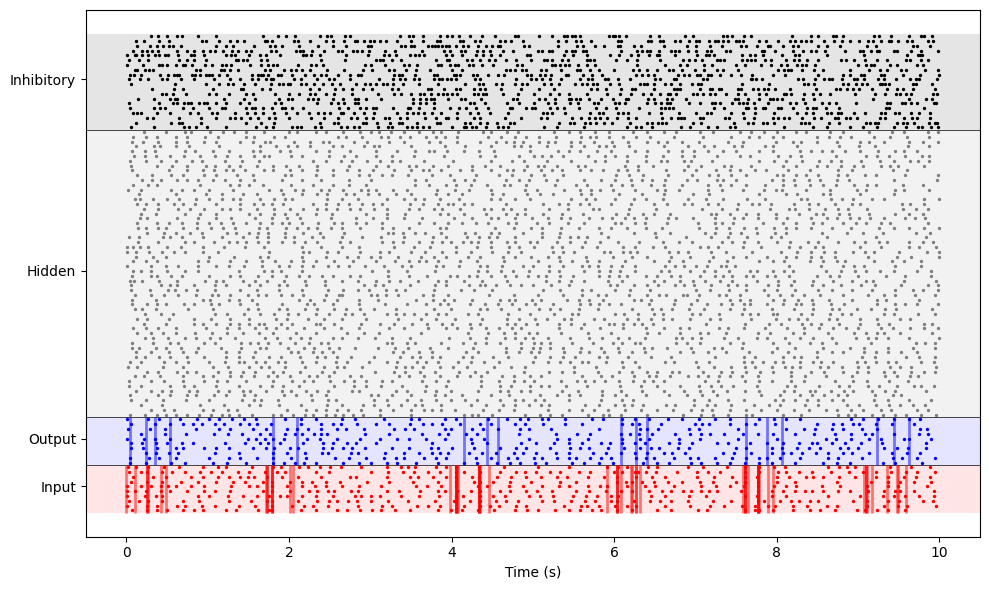

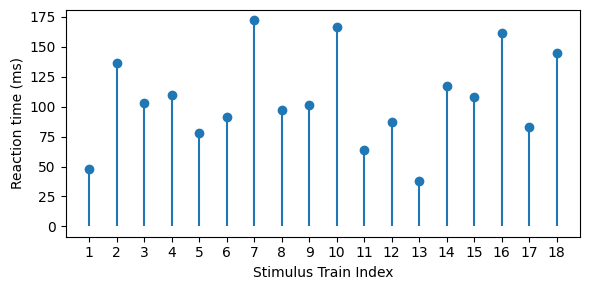

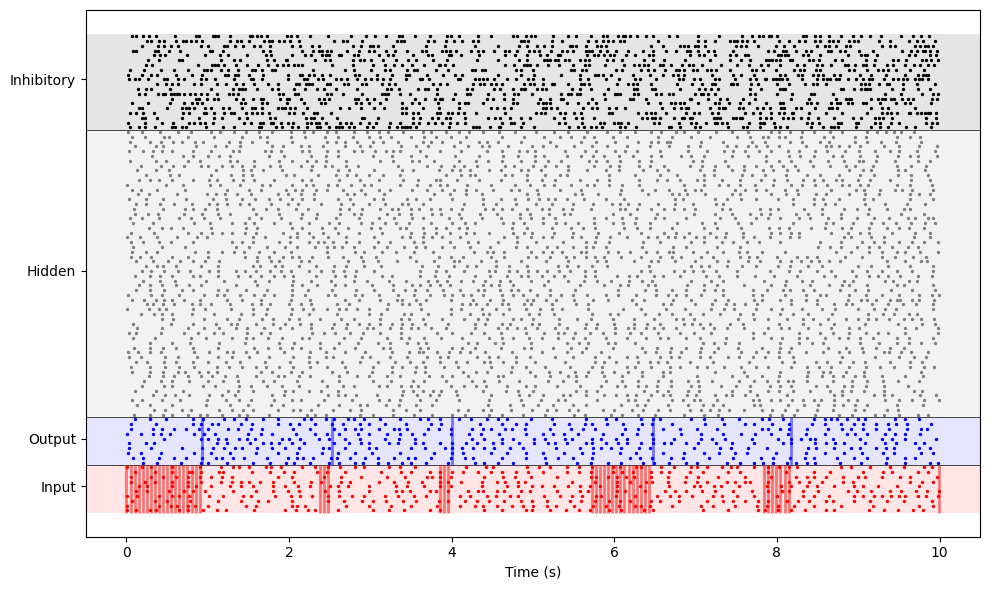

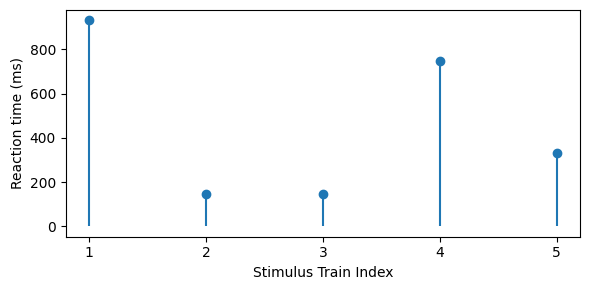

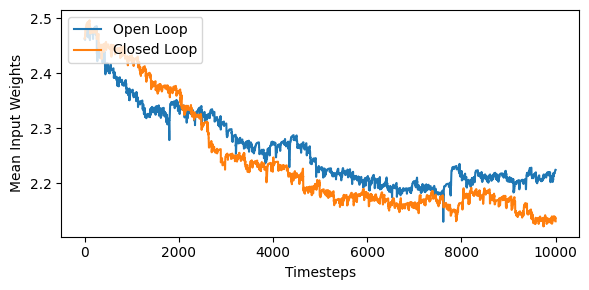

In [54]:
spikes_oo, rt_oo, abs_rt_oo, spk_oo, woo = run_uncontrolled_open_loop(net, 10000)
net.plot_raster(spikes_oo, reaction_times=abs_rt_oo, stim_times=spk_oo)
plot_reaction_times(rt_oo)
spikes_cc, rt_cc, abs_rt_cc, spk_cc, wcc = run_closed_loop(net, 10000)
net.plot_raster(spikes_cc, reaction_times=abs_rt_cc, stim_times=spk_cc)
plot_reaction_times(rt_cc)
plot_mean_weights(woo, wcc)

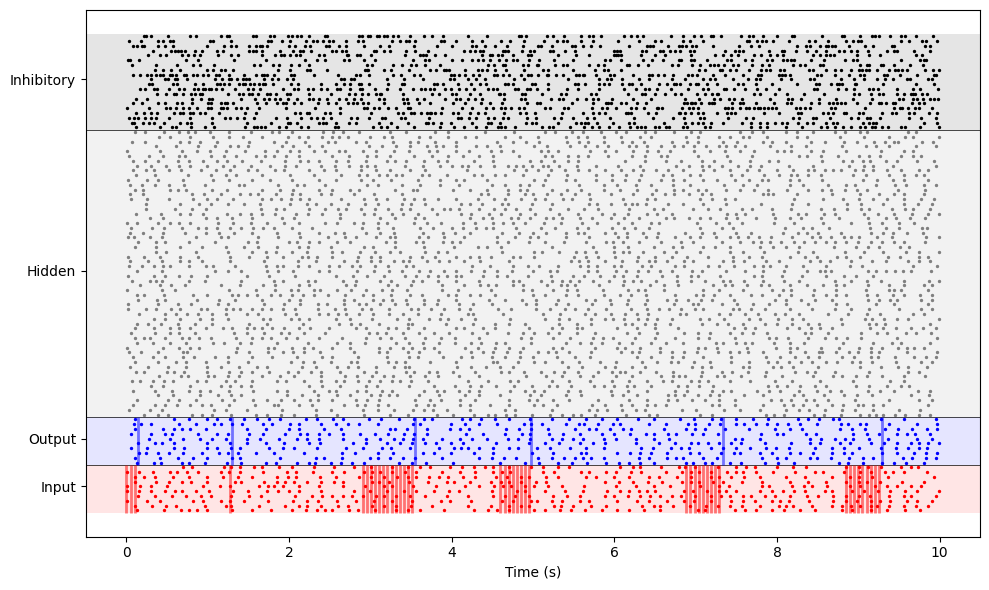

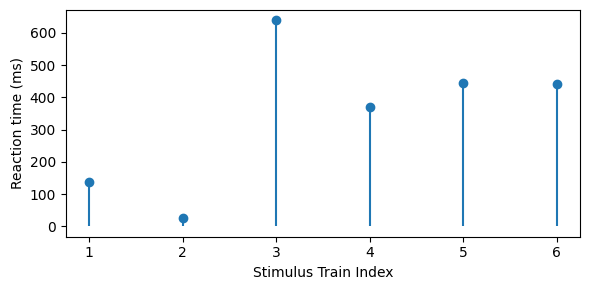

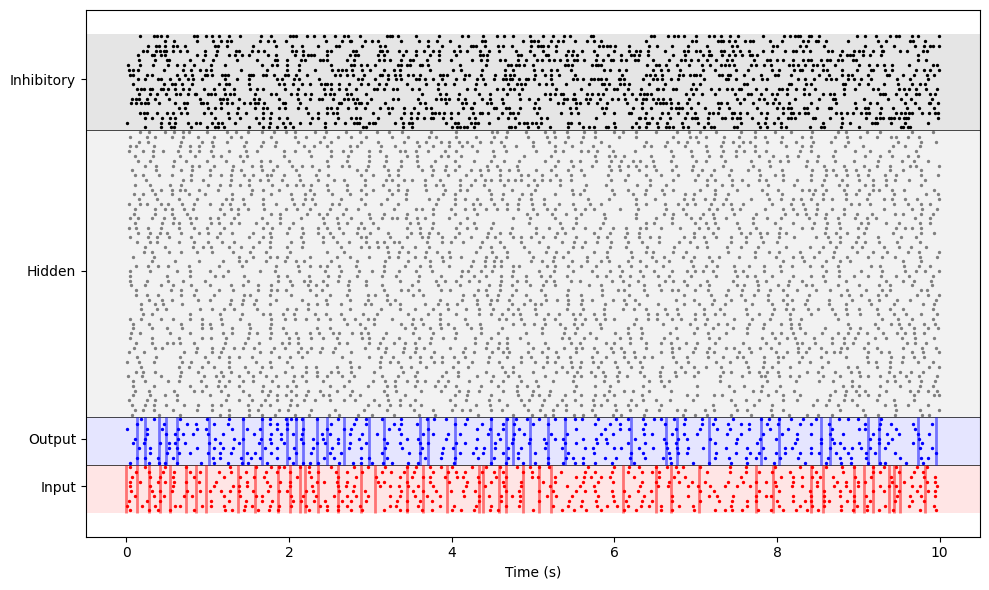

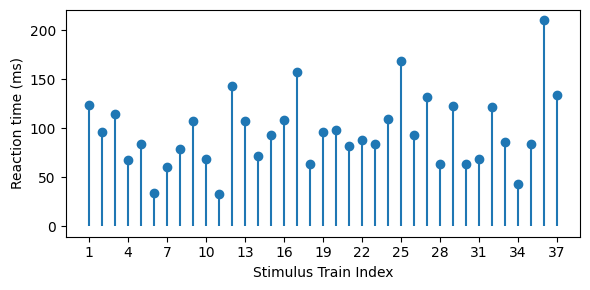

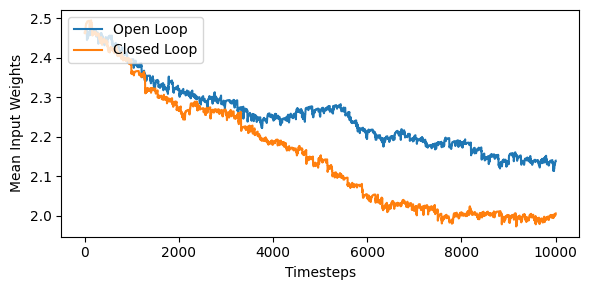

In [55]:
spikes_cc, rt_cc, abs_rt_cc, spk_cc, wcc = run_closed_loop(net, 10000)
net.plot_raster(spikes_cc, reaction_times=abs_rt_cc, stim_times=spk_cc)
plot_reaction_times(rt_cc)
spikes_oo, rt_oo, abs_rt_oo, spk_oo, woo = run_controlled_open_loop(net, spk_cc, 10000)
net.plot_raster(spikes_oo, reaction_times=abs_rt_oo, stim_times=spk_oo)
plot_reaction_times(rt_oo)
plot_mean_weights(woo, wcc)

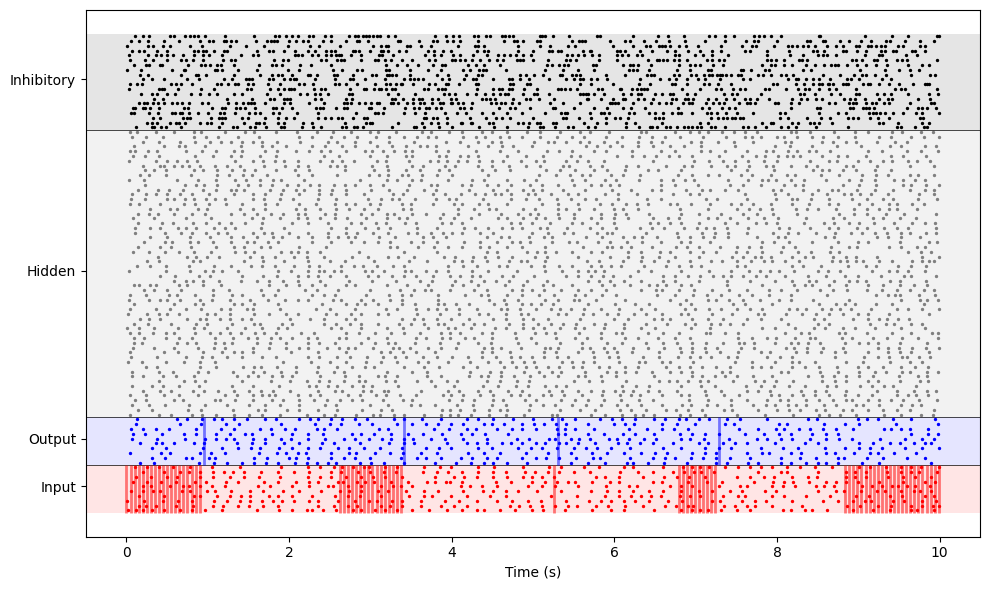

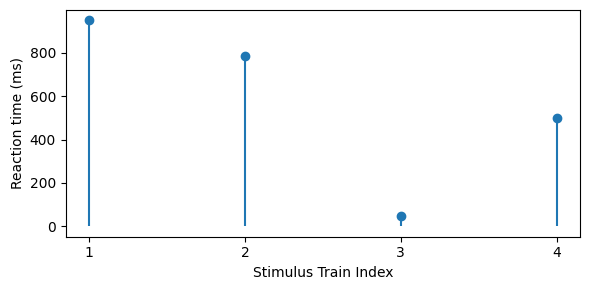

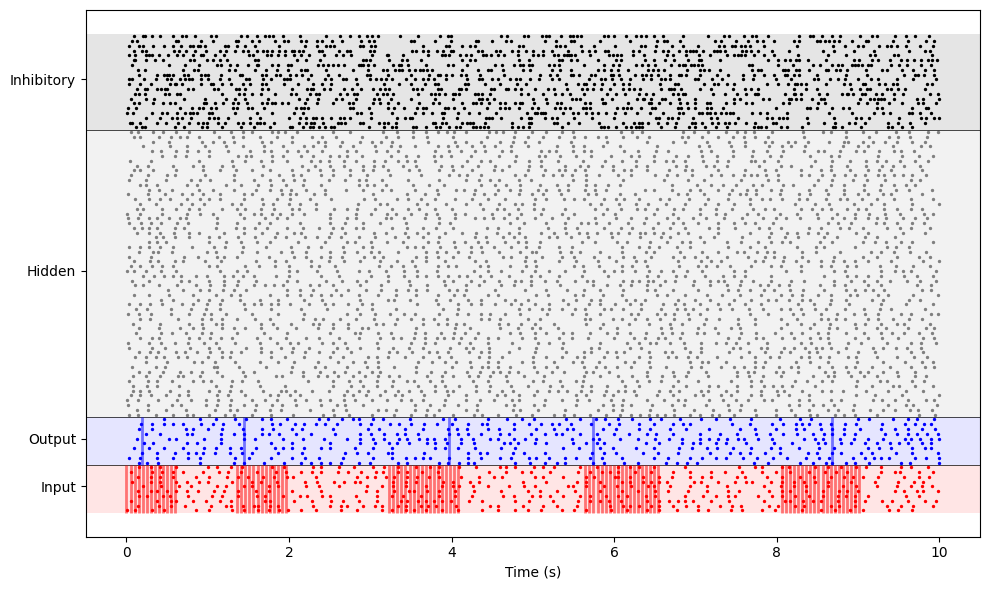

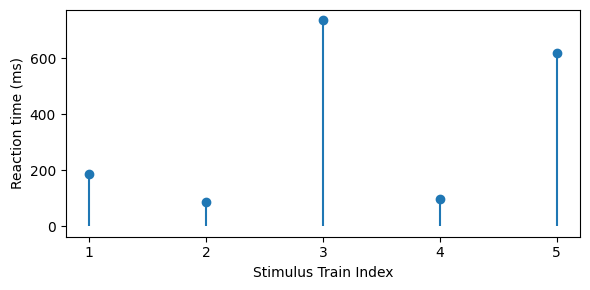

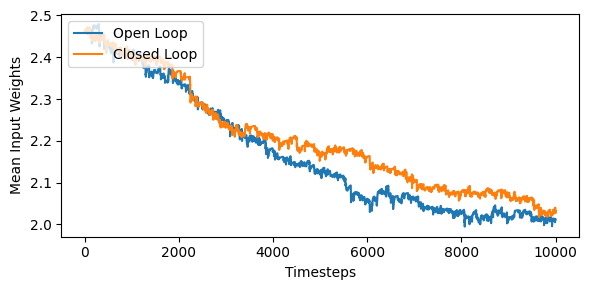

In [59]:
spikes_cc, rt_cc, abs_rt_cc, spk_cc, wcc = run_closed_loop(net, 10000)
net.plot_raster(spikes_cc, reaction_times=abs_rt_cc, stim_times=spk_cc)
plot_reaction_times(rt_cc)
spikes_oo, rt_oo, abs_rt_oo, spk_oo, woo = run_periodic_open_loop(net, 10000)
net.plot_raster(spikes_oo, reaction_times=abs_rt_oo, stim_times=spk_oo)
plot_reaction_times(rt_oo)
plot_mean_weights(woo, wcc)

### 1.3 Open and Closed Loop: Longer Test Runs

In [60]:
T = 500*1e3  # 500 seconds in ms

#### 1.3.1 Similar Spikes/Cycle

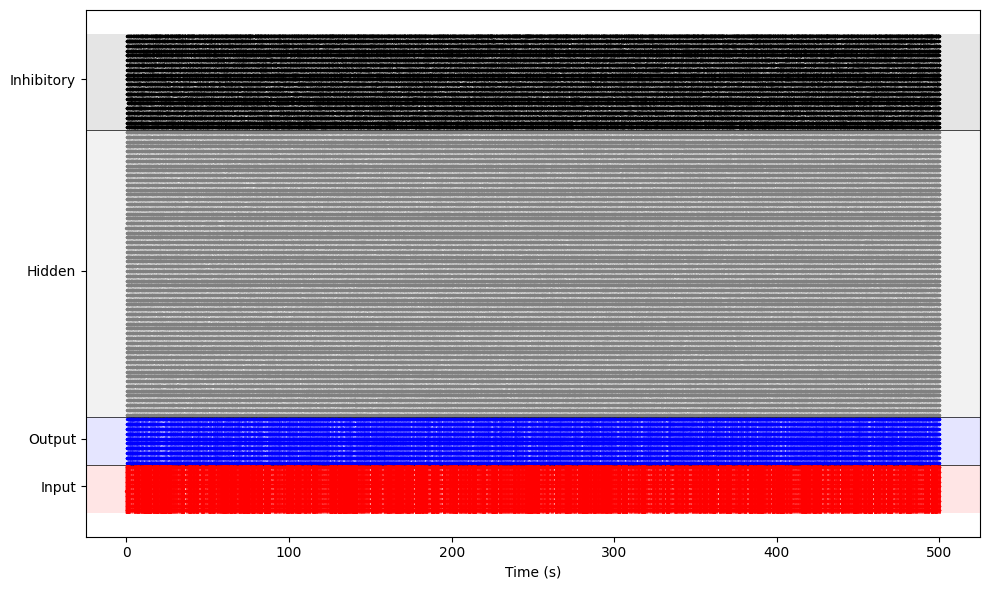

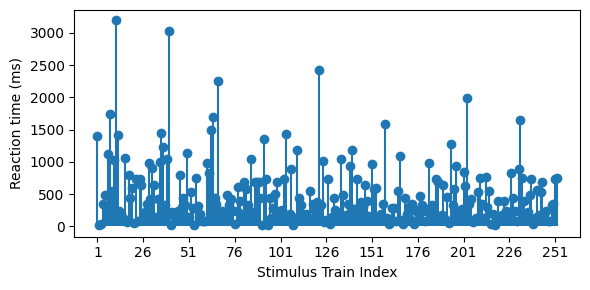

In [440]:
spikes_c, rt_c, abs_rt_c, spk_c, wc = run_closed_loop(net, T)
net.plot_raster(spikes_c, reaction_times=abs_rt_c, stim_times=spk_c)
plot_reaction_times(rt_c)

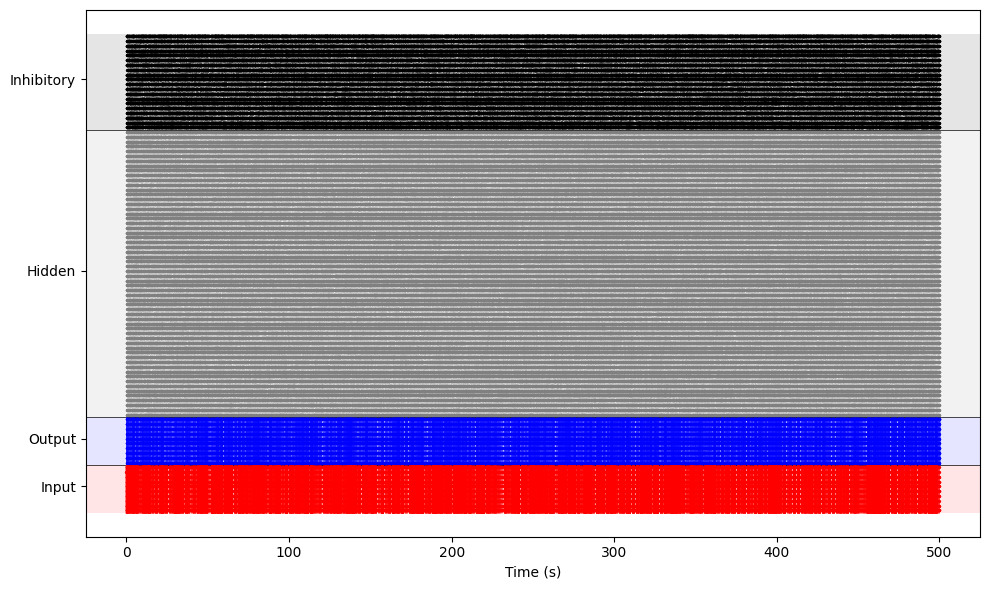

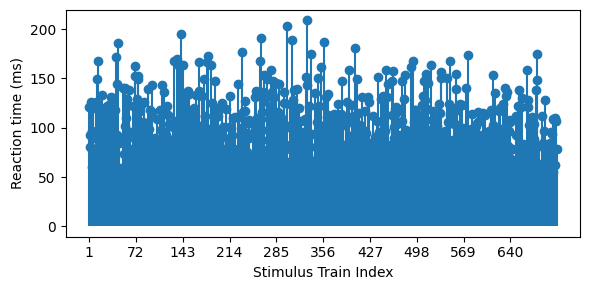

In [448]:
spikes_o, rt_o, abs_rt_o, spk_o, wo = run_uncontrolled_open_loop(net, T)
net.plot_raster(spikes_o, reaction_times=abs_rt_o, stim_times=spk_o)
plot_reaction_times(rt_o)

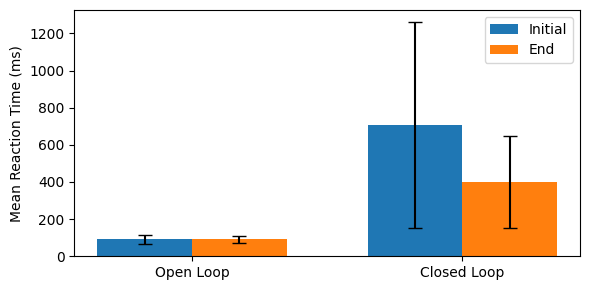

In [449]:
plot_mean_rt(rt_o, rt_c)

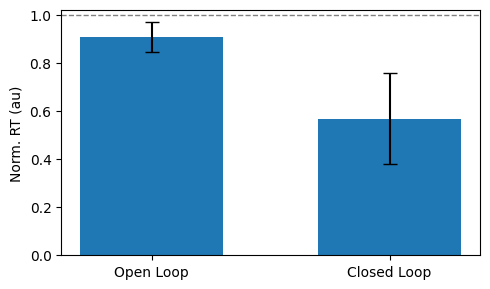

In [450]:
plot_rt_ratio(rt_o, rt_c)

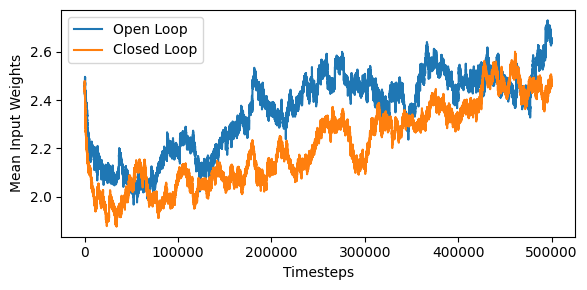

In [451]:
plot_mean_weights(wo, wc)

In [452]:
np.round((wo - wc)[:7], 4)

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    , -0.0009, -0.0011])

In [453]:
pauses_c = (np.diff(spk_c) > 999).sum()/500 # pause range
pauses_o = (np.diff(spk_o) > 999).sum()/500 # off range
print(pauses_c, pauses_o)

def mean_segment_freq(spk, pause_thresh=999):
    # find where a pause (> pause_thresh ms) occurs
    break_idxs = np.where(np.diff(spk) > pause_thresh)[0] + 1
    # split into continuous segments
    segments  = np.split(spk, break_idxs)
    # compute spikes/sec for each segment
    freqs = [
        (len(seg)-1) / ((seg[-1] - seg[0]) / 1000.0)   # N-1 intervals
        for seg in segments
        if len(seg) > 1
    ]
    return np.mean(freqs)
print(mean_segment_freq(spk_c), mean_segment_freq(spk_o))

def on_off_lengths(spk, pause_thresh=999):
    # indices where a new on-epoch starts
    break_idx = np.where(np.diff(spk) > pause_thresh)[0] + 1
    segments  = np.split(spk, break_idx)
    # on-durations (ms): last-pulse − first-pulse in each segment
    on_ms  = np.array([seg[-1] - seg[0] for seg in segments])
    # off-durations (ms): the large gaps themselves
    off_ms = np.diff(spk)[np.diff(spk) > pause_thresh]
    return on_ms.mean() / 1000.0, off_ms.mean() / 1000.0
on_c,  off_c  = on_off_lengths(spk_c)
on_o,  off_o  = on_off_lengths(spk_o)
print(f"closed-loop   mean on = {on_c:.3f}s   mean off = {off_c:.3f}s")
print(f"open-loop     mean on = {on_o:.3f}s   mean off = {off_o:.3f}s")

0.504 0.5
20.0 27.920918713077715
closed-loop   mean on = 0.439s   mean off = 1.543s
open-loop     mean on = 0.347s   mean off = 1.650s


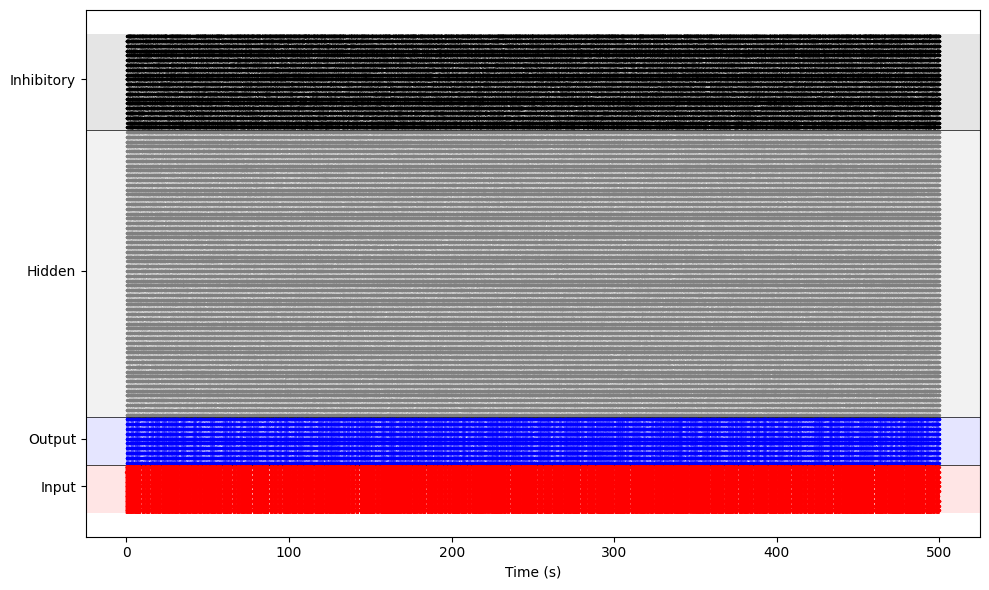

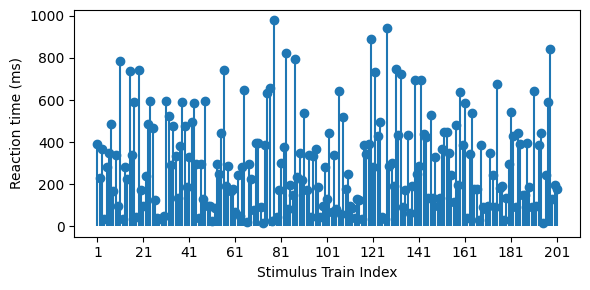

In [454]:
spikes_o, rt_o, abs_rt_o, spk_o, wo = run_periodic_open_loop(net, T)
net.plot_raster(spikes_o, reaction_times=abs_rt_o, stim_times=spk_o)
plot_reaction_times(rt_o)

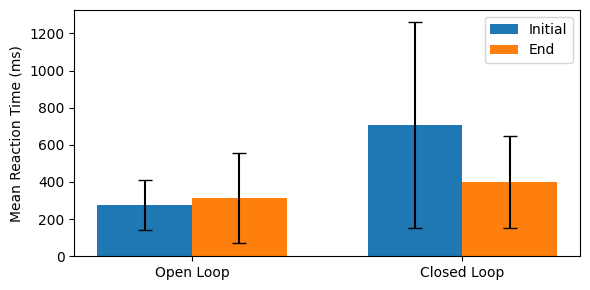

In [458]:
plot_mean_rt(rt_o, rt_c)

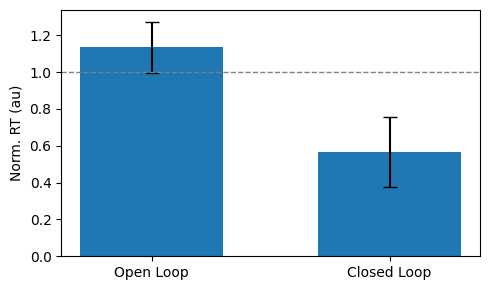

In [456]:
plot_rt_ratio(rt_o, rt_c)

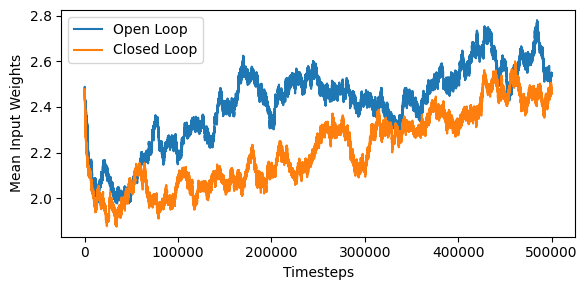

In [460]:
plot_mean_weights(wo, wc)

In [459]:
pauses_c = (np.diff(spk_c) > 999).sum()/500 # pause range
pauses_o = (np.diff(spk_o) > 999).sum()/500 # off range
print(pauses_c, pauses_o)
print(mean_segment_freq(spk_c), mean_segment_freq(spk_o))
on_c,  off_c  = on_off_lengths(spk_c)
on_o,  off_o  = on_off_lengths(spk_o)
print(f"closed-loop   mean on = {on_c:.3f}s   mean off = {off_c:.3f}s")
print(f"open-loop     mean on = {on_o:.3f}s   mean off = {off_o:.3f}s")

0.504 0.324
20.0 17.529139297359514
closed-loop   mean on = 0.439s   mean off = 1.543s
open-loop     mean on = 1.554s   mean off = 1.517s


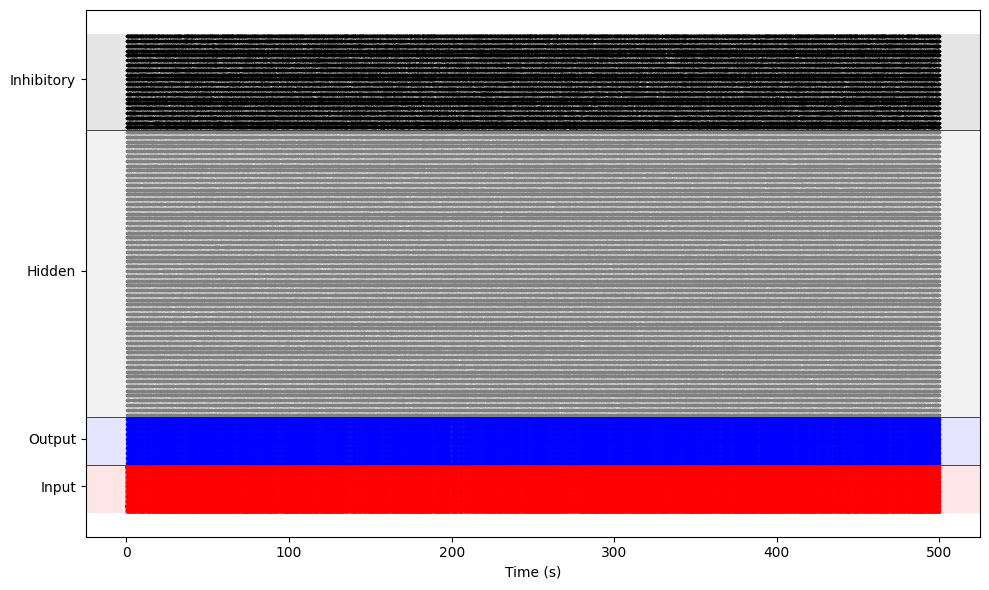

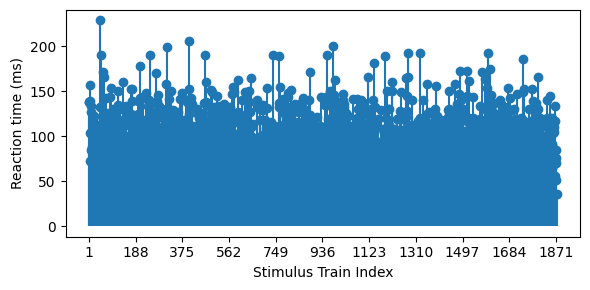

In [461]:
spikes_o, rt_o, abs_rt_o, spk_o, wo = run_controlled_open_loop(net, spk_c, T)
net.plot_raster(spikes_o, reaction_times=abs_rt_o, stim_times=spk_o)
plot_reaction_times(rt_o)

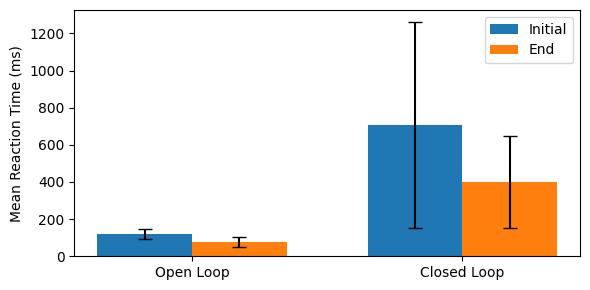

In [462]:
plot_mean_rt(rt_o, rt_c)

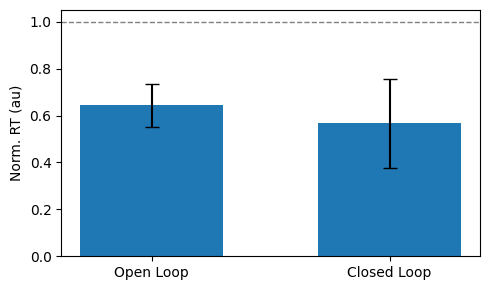

In [463]:
plot_rt_ratio(rt_o, rt_c)

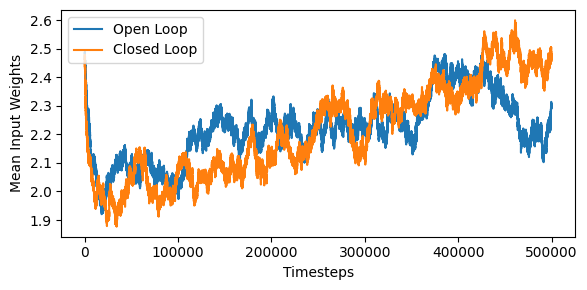

In [464]:
plot_mean_weights(wo, wc)

#### 1.3.2 More Spikes/Cycle

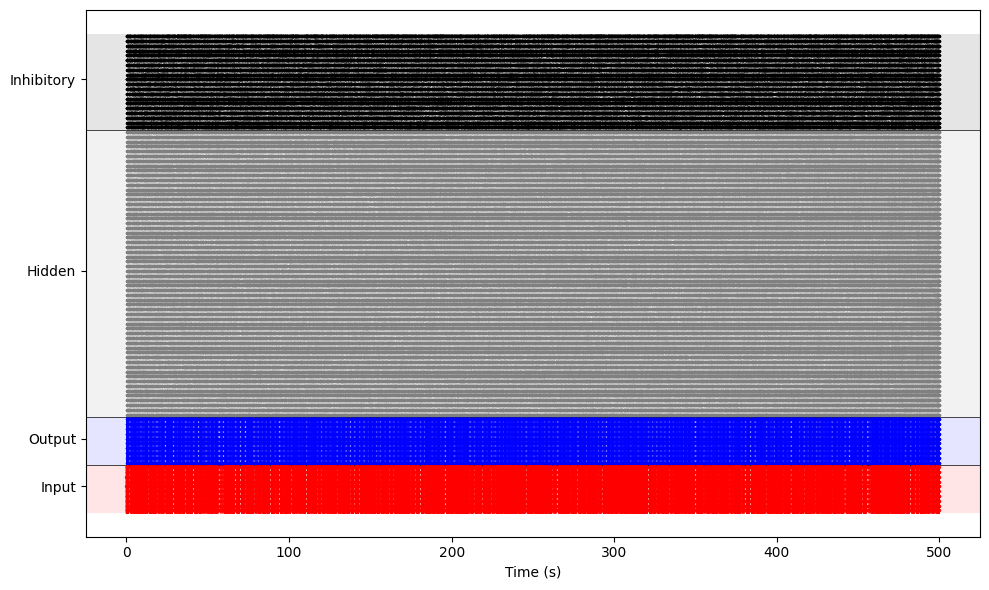

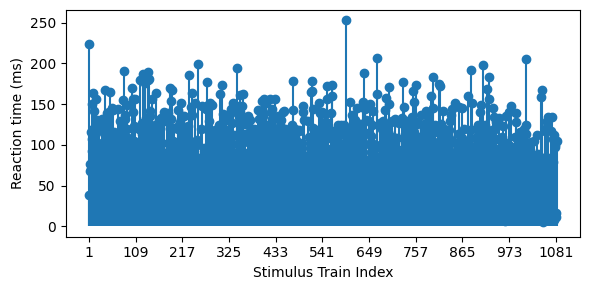

In [465]:
spikes_o, rt_o, abs_rt_o, spk_o, wo = run_uncontrolled_open_loop(net, T, on_range=(750,1250))
net.plot_raster(spikes_o, reaction_times=abs_rt_o, stim_times=spk_o)
plot_reaction_times(rt_o)

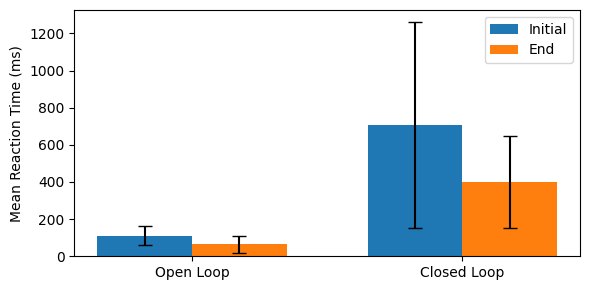

In [466]:
plot_mean_rt(rt_o, rt_c)

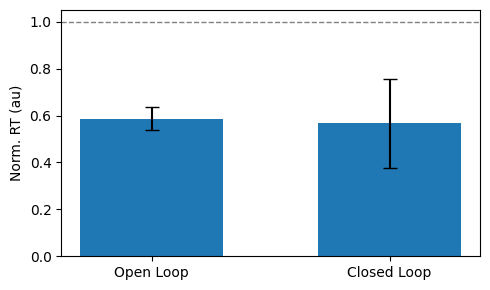

In [467]:
plot_rt_ratio(rt_o, rt_c)

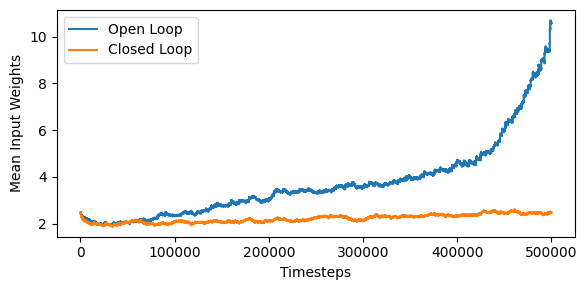

In [468]:
plot_mean_weights(wo, wc)

In [469]:
pauses_c = (np.diff(spk_c) > 999).sum()/500 # pause range
pauses_o = (np.diff(spk_o) > 999).sum()/500 # off range
print(pauses_c, pauses_o)
print(mean_segment_freq(spk_c), mean_segment_freq(spk_o))
on_c,  off_c  = on_off_lengths(spk_c)
on_o,  off_o  = on_off_lengths(spk_o)
print(f"closed-loop   mean on = {on_c:.3f}s   mean off = {off_c:.3f}s")
print(f"open-loop     mean on = {on_o:.3f}s   mean off = {off_o:.3f}s")

0.504 0.398
20.0 22.06927913825353
closed-loop   mean on = 0.439s   mean off = 1.543s
open-loop     mean on = 0.849s   mean off = 1.655s


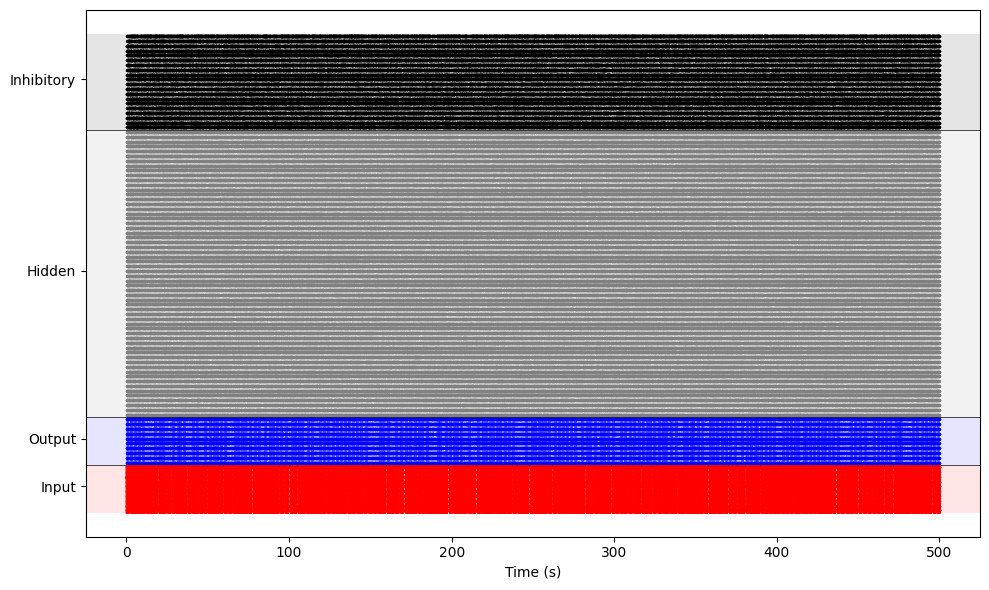

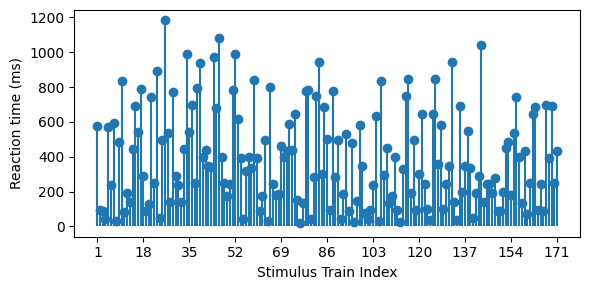

In [470]:
spikes_o, rt_o, abs_rt_o, spk_o, wo = run_periodic_open_loop(net, T, on_range=(750,1250), off_range=(1000,2000))
net.plot_raster(spikes_o, reaction_times=abs_rt_o, stim_times=spk_o)
plot_reaction_times(rt_o)

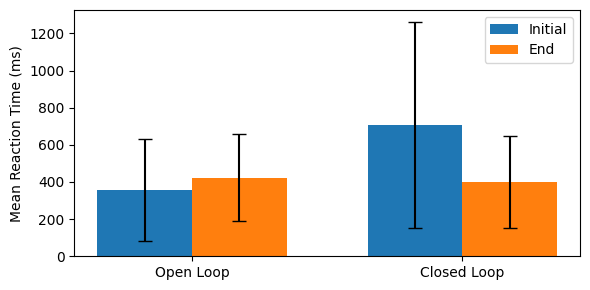

In [471]:
plot_mean_rt(rt_o, rt_c)

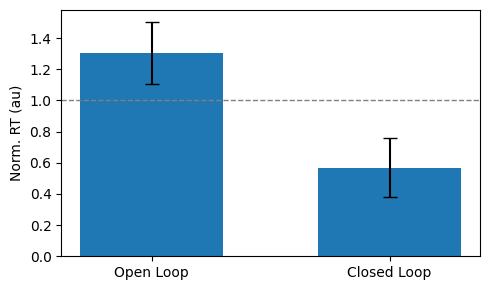

In [472]:
plot_rt_ratio(rt_o, rt_c)

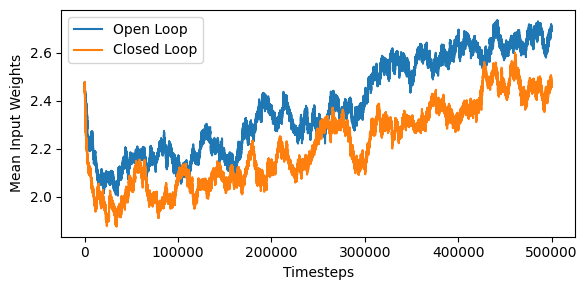

In [473]:
plot_mean_weights(wo, wc)

In [474]:
pauses_c = (np.diff(spk_c) > 999).sum()/500 # pause range
pauses_o = (np.diff(spk_o) > 999).sum()/500 # off range
print(pauses_c, pauses_o)
print(mean_segment_freq(spk_c), mean_segment_freq(spk_o))
on_c,  off_c  = on_off_lengths(spk_c)
on_o,  off_o  = on_off_lengths(spk_o)
print(f"closed-loop   mean on = {on_c:.3f}s   mean off = {off_c:.3f}s")
print(f"open-loop     mean on = {on_o:.3f}s   mean off = {off_o:.3f}s")

0.504 0.396
20.0 20.0
closed-loop   mean on = 0.439s   mean off = 1.543s
open-loop     mean on = 0.986s   mean off = 1.533s


#### 1.3.3 Symmetric STDP

In [61]:
snet = IzhikevichNetwork(80, 20, 10, 10, seed=14, noise_std = 5.0, A_LTP=1.0, 
                         A_LTD=1.0, tau_LTP=20.0, tau_LTD=20.0)

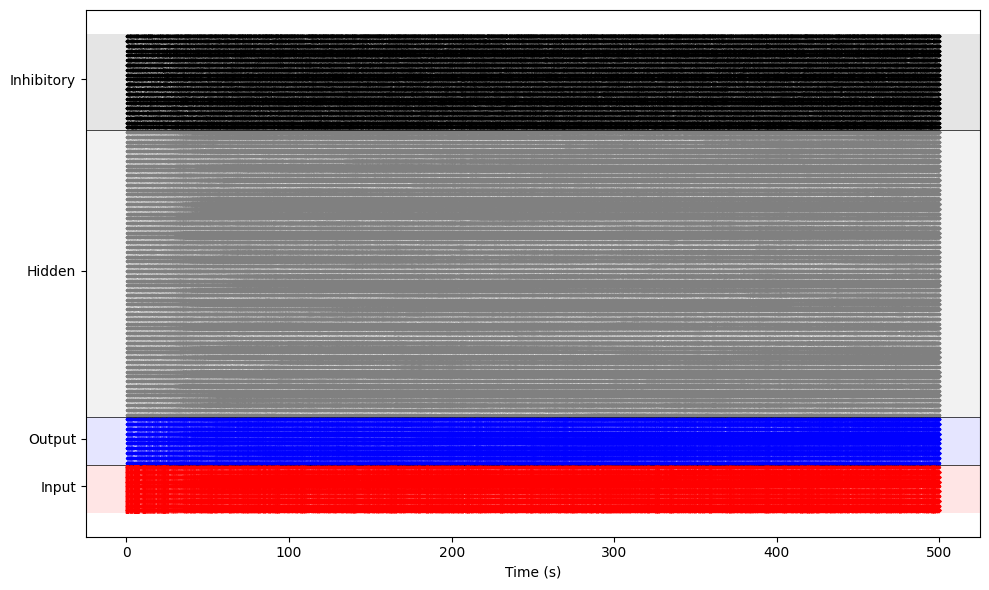

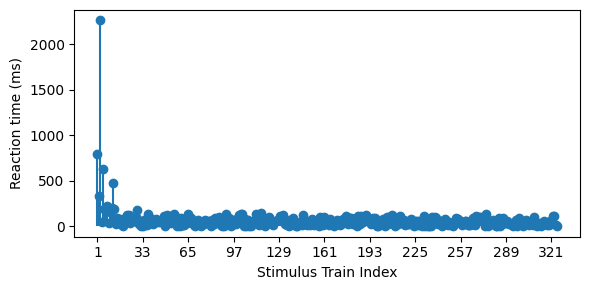

In [62]:
spikes_c, rt_c, abs_rt_c, spk_c, wc = run_closed_loop(snet, T)
net.plot_raster(spikes_c, reaction_times=abs_rt_c, stim_times=spk_c)
plot_reaction_times(rt_c)

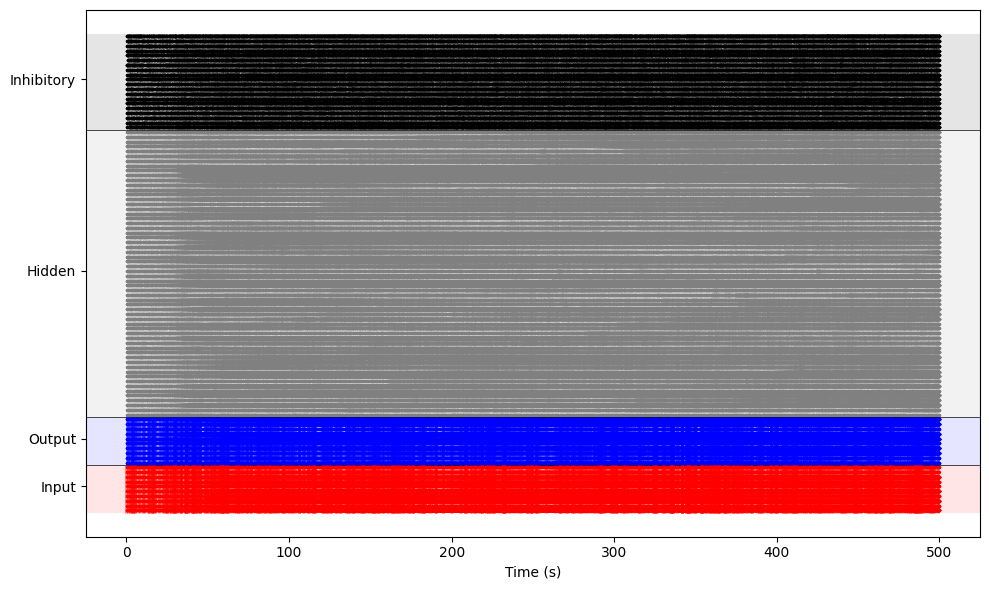

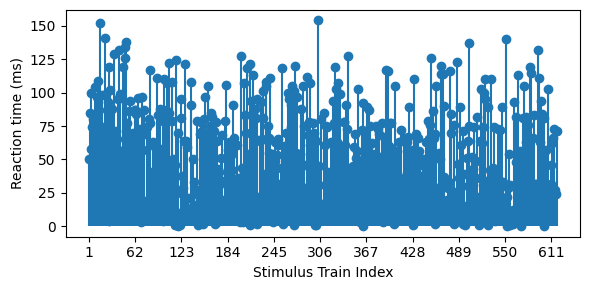

In [63]:
spikes_o, rt_o, abs_rt_o, spk_o, wo = run_controlled_open_loop(snet, spk_c, T)
net.plot_raster(spikes_o, reaction_times=abs_rt_o, stim_times=spk_o)
plot_reaction_times(rt_o)

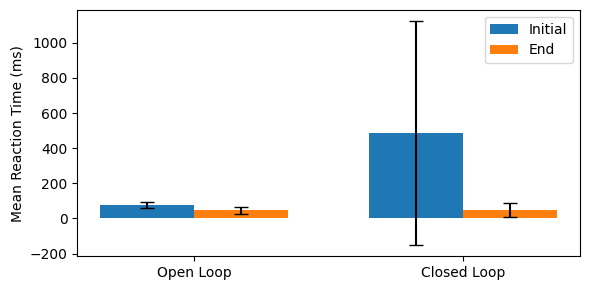

In [64]:
plot_mean_rt(rt_o, rt_c)

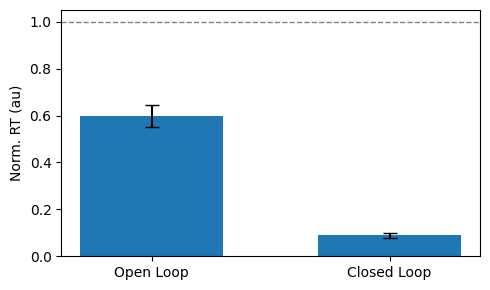

In [65]:
plot_rt_ratio(rt_o, rt_c)

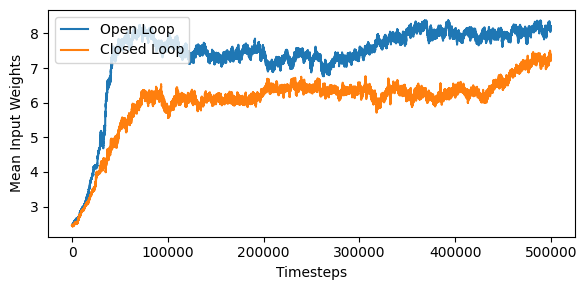

In [66]:
plot_mean_weights(wo, wc)

In [67]:
(wo - wc)[:6]

array([0., 0., 0., 0., 0., 0.])

## 2. Multiple Networks: Results Validation Run

In [15]:
import multiprocessing
from joblib import Parallel, delayed
from itertools import chain
from scipy import stats

In [16]:
n_cpus = multiprocessing.cpu_count()
n_nets = 20
nets = [IzhikevichNetwork(80, 20, 10, 10, noise_std=5.0, A_LTP=1.0, A_LTD=1.1,
                          tau_LTP=20.0, tau_LTD=24.0) for _ in range(n_nets)]
snets = [IzhikevichNetwork(80, 20, 10, 10, seed=14, noise_std = 5.0, A_LTP=1.0, A_LTD=1.0,
                           tau_LTP=20.0, tau_LTD=20.0) for _ in range(n_nets)]
T = 2000*1e3 # 2000 seconds in ms

### 2.1 Plotting and Statistical Analysis Code

In [10]:
def plot_rt_ratio(rt_o, rt_c, window=20, variation=5):
    if not isinstance(rt_o, (list, tuple)):
        rt_o = [rt_o]
    if not isinstance(rt_c, (list, tuple)):
        rt_c = [rt_c]
    assert len(rt_o) == len(rt_c) # must have same number of runs
    M = len(rt_o)
    
    mu_o = mu_c = err_o = err_c = None
    if M > 1:
        # compute one ratio per run
        ratios_o = np.array([np.nanmean(o[-window:]) / np.nanmean(o[:window]) for o in rt_o])
        ratios_c = np.array([np.nanmean(c[-window:]) / np.nanmean(c[:window]) for c in rt_c])
        # mean ± sem
        mu_o, mu_c = ratios_o.mean(), ratios_c.mean()
        err_o = ratios_o.std() / np.sqrt(M)
        err_c = ratios_c.std() / np.sqrt(M)
    else:
        # single run: sweep window for robustness
        o0 = rt_o[0]
        c0 = rt_c[0]
        # build varied window sizes
        ws = np.arange(max(1, window-variation), window+variation+1)
        # ratios across varied windows
        ro = np.array([np.nanmean(o0[-w:]) / np.nanmean(o0[:w]) for w in ws])
        rc = np.array([np.nanmean(c0[-w:]) / np.nanmean(c0[:w]) for w in ws])
        mu_o, mu_c = ro.mean(), rc.mean()
        # error‐bars = sd of those ratios
        err_o, err_c = ro.std(), rc.std()

    # plotting
    labels = ['Open Loop', 'Closed Loop']
    x = np.arange(2)
    width = 0.5
    plt.figure(figsize=(5, 3))
    plt.bar(x, [mu_o, mu_c], width, yerr=[err_o, err_c], capsize=5)
    plt.xticks(x, labels)
    plt.ylabel('Norm. RT (au)')
    plt.axhline(1, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

In [11]:
def plot_mean_weights(wo, wc):
    arr_wo = np.atleast_2d(wo)
    arr_wc = np.atleast_2d(wc)
    M, T = arr_wo.shape

    # mean over nets
    mu_wo = np.nanmean(arr_wo, axis=0)
    mu_wc = np.nanmean(arr_wc, axis=0)

    plt.figure(figsize=(6, 3))
    if M > 1:
        # sem ribbons
        sem_wo = np.nanstd(arr_wo, axis=0) / np.sqrt(M)
        sem_wc = np.nanstd(arr_wc, axis=0) / np.sqrt(M)
        t = np.arange(T)

        plt.plot(t, mu_wo, label='Open Loop')
        plt.fill_between(t, mu_wo - sem_wo, mu_wo + sem_wo, alpha=0.3)

        plt.plot(t, mu_wc, label='Closed Loop')
        plt.fill_between(t, mu_wc - sem_wc, mu_wc + sem_wc, alpha=0.3)
    else:
        # single‐net simply plot
        t = np.arange(T)
        plt.plot(t, mu_wo, label='Open Loop')
        plt.plot(t, mu_wc, label='Closed Loop')

    plt.xlabel('Timesteps')
    plt.ylabel('Mean Input Weights')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
# one-sampled t-test (or rank test) for initial-end ratios
def rt_stat_tests(rt_o, rt_c, window=20, variation=5, nonparametric=False):
    if not isinstance(rt_o, (list, tuple)):
        rt_o = [rt_o]
    if not isinstance(rt_c, (list, tuple)):
        rt_c = [rt_c]
    assert len(rt_o) == len(rt_c) # must have same number of runs
    M = len(rt_o)

    if M > 1:
        # compute one ratio per run
        ratios_o = np.array([np.nanmean(o[-window:]) / np.nanmean(o[:window]) for o in rt_o])
        ratios_c = np.array([np.nanmean(c[-window:]) / np.nanmean(c[:window]) for c in rt_c])
    else:
        # single run: sweep window for robustness
        o0 = rt_o[0]
        c0 = rt_c[0]
        # build varied window sizes
        ws = np.arange(max(1, window-variation), window+variation+1)
        # ratios across varied windows
        ratios_o = np.array([np.nanmean(o0[-w:]) / np.nanmean(o0[:w]) for w in ws])
        ratios_c = np.array([np.nanmean(c0[-w:]) / np.nanmean(c0[:w]) for w in ws])

    results = {}
    if nonparametric:
        # wilcoxon signed‐rank: test median difference vs 0
        _, p_o = stats.wilcoxon(ratios_o - 1, alternative='two-sided', zero_method='wilcox')
        _, p_c = stats.wilcoxon(ratios_c - 1, alternative='two-sided', zero_method='wilcox')
    else:
        # one‐sample t‐test vs popmean = 1
        _, p_o = stats.ttest_1samp(ratios_o, popmean=1, nan_policy='omit')
        _, p_c = stats.ttest_1samp(ratios_c, popmean=1, nan_policy='omit')
    results['open_initial_vs_end']   = p_o
    results['closed_initial_vs_end'] = p_c
    return results

### 2.2 Long Parallel Validation Runs

In [527]:
# run closed-loop simulations in parallel
cls_tasks = chain(
    (delayed(run_closed_loop)(net, T)  for net  in nets),
    (delayed(run_closed_loop)(snet, T) for snet in snets),
)
cls_results = Parallel(n_jobs=n_cpus)(cls_tasks)
results_c, results_sc = cls_results[:len(nets)], cls_results[len(nets):]
spikes_c, rt_c, abs_rt_c, spk_c, wc = zip(*results_c)
spikes_sc, rt_sc, abs_rt_sc, spk_sc, wsc = zip(*results_sc)
wc_mat = np.vstack(wc)
wsc_mat = np.vstack(wsc)

In [528]:
# run open-loop simulations in parallel
ols_tasks = chain(
    (delayed(run_uncontrolled_open_loop)(net, T)  for net in nets),
    (delayed(run_uncontrolled_open_loop)(snet, T) for snet in snets),
)
ols_results = Parallel(n_jobs=n_cpus)(ols_tasks)
results_o, results_so = ols_results[:len(nets)], ols_results[len(nets):]
spikes_o, rt_o, abs_rt_o, spk_o, wo = zip(*results_o)
spikes_so, rt_so, abs_rt_so, spk_so, wso = zip(*results_so)
wo_mat = np.vstack(wo)
wso_mat = np.vstack(wso)

In [529]:
np.mean([len(spk_c[i]) - len(spk_o[i]) for i in range(len(nets))])/2000

np.float64(0.32689999999999997)

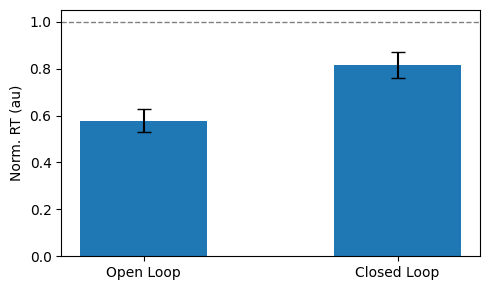

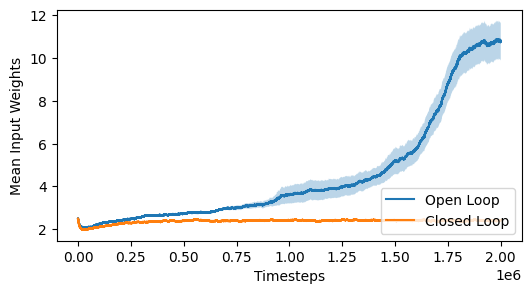

In [530]:
plot_rt_ratio(rt_o, rt_c)
plot_mean_weights(wo_mat, wc_mat)

In [531]:
pvals = rt_stat_tests(rt_o, rt_c)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 5.627e-08
closed_initial_vs_end       : p = 0.003846


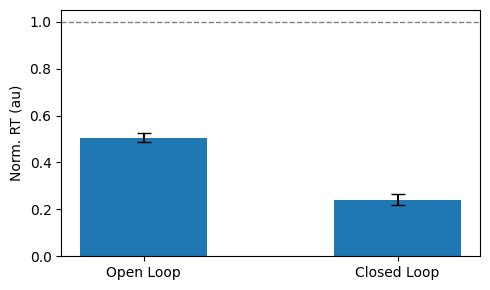

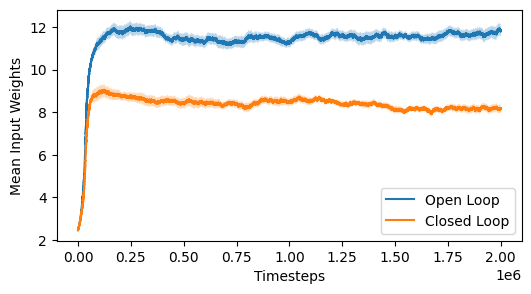

In [532]:
plot_rt_ratio(rt_so, rt_sc)
plot_mean_weights(wso_mat, wsc_mat)

In [533]:
pvals = rt_stat_tests(rt_so, rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 1.199e-15
closed_initial_vs_end       : p = 1.942e-18


In [560]:
# run open-loop simulations in parallel
ols_tasks1 = chain(
    (delayed(run_periodic_open_loop)(net, T, on_range=(400, 600), off_range=(1000, 2000))  for net in nets),
    (delayed(run_periodic_open_loop)(snet, T, on_range=(400, 600), off_range=(1000, 2000)) for snet in snets),
)
ols_results1 = Parallel(n_jobs=n_cpus)(ols_tasks1)
results_o1, results_so1 = ols_results1[:len(nets)], ols_results1[len(nets):]
spikes_o1, rt_o1, abs_rt_o1, spk_o1, wo1 = zip(*results_o1)
spikes_so1, rt_so1, abs_rt_so1, spk_so1, wso1 = zip(*results_so1)
wo1_mat = np.vstack(wo1)
wso1_mat = np.vstack(wso1)

In [561]:
np.mean([len(spk_c[i]) - len(spk_o1[i]) for i in range(len(nets))])/2000

np.float64(-0.19690000000000002)

In [562]:
np.mean([len(spk_o[i]) - len(spk_o1[i]) for i in range(len(nets))])/2000

np.float64(-0.5237999999999999)

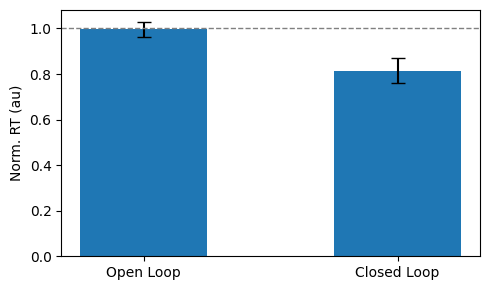

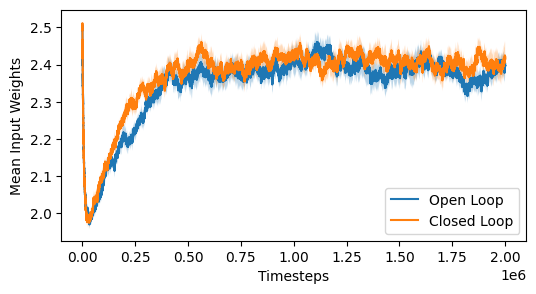

In [563]:
plot_rt_ratio(rt_o1, rt_c)
plot_mean_weights(wo1_mat, wc_mat)

In [564]:
pvals = rt_stat_tests(rt_o1, rt_c)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 0.93
closed_initial_vs_end       : p = 0.003846


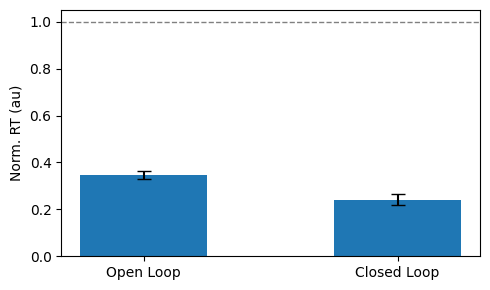

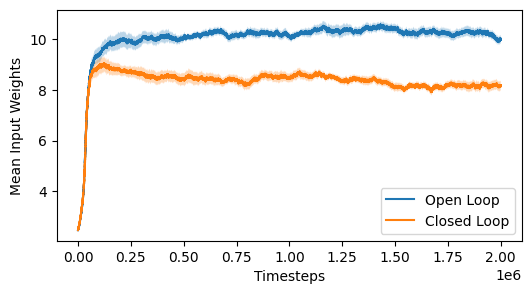

In [565]:
plot_rt_ratio(rt_so1, rt_sc)
plot_mean_weights(wso1_mat, wsc_mat)

In [566]:
pvals = rt_stat_tests(rt_so1, rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 3.582e-19
closed_initial_vs_end       : p = 1.942e-18


In [541]:
# run open-loop simulations in parallel
ols_tasks2 = chain(
    (delayed(run_uncontrolled_open_loop)(net, T, on_range=(750,1250))  for net in nets),
    (delayed(run_uncontrolled_open_loop)(snet, T, on_range=(750,1250)) for snet in snets),
)
ols_results2 = Parallel(n_jobs=n_cpus)(ols_tasks2)
results_o2, results_so2 = ols_results2[:len(nets)], ols_results2[len(nets):]
spikes_o2, rt_o2, abs_rt_o2, spk_o2, wo2 = zip(*results_o2)
spikes_so2, rt_so2, abs_rt_so2, spk_so2, wso2 = zip(*results_so2)
wo2_mat = np.vstack(wo2)
wso2_mat = np.vstack(wso2)

In [542]:
np.mean([len(spk_c[i]) - len(spk_o2[i]) for i in range(len(nets))])/2000

np.float64(-2.5563000000000002)

In [567]:
np.mean([len(spk_o[i]) - len(spk_o2[i]) for i in range(len(nets))])/2000

np.float64(-2.8832)

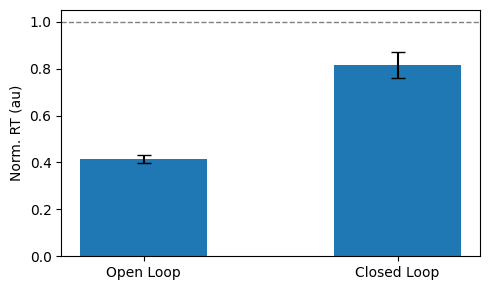

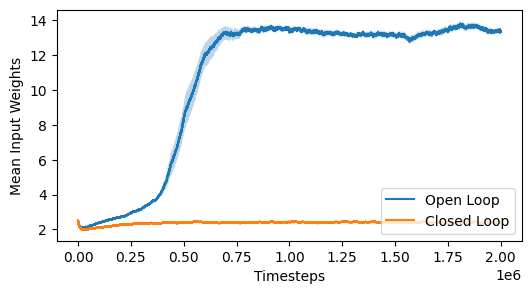

In [543]:
plot_rt_ratio(rt_o2, rt_c)
plot_mean_weights(wo2_mat, wc_mat)

In [544]:
pvals = rt_stat_tests(rt_o2, rt_c)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 4.228e-18
closed_initial_vs_end       : p = 0.003846


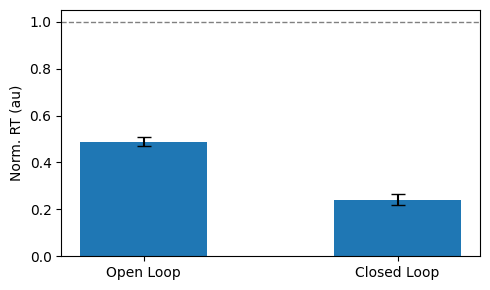

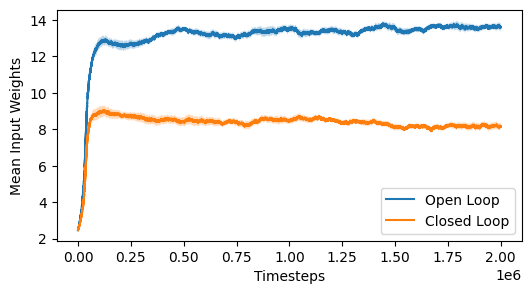

In [545]:
plot_rt_ratio(rt_so2, rt_sc)
plot_mean_weights(wso2_mat, wsc_mat)

In [546]:
pvals = rt_stat_tests(rt_so2, rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 2.495e-16
closed_initial_vs_end       : p = 1.942e-18


In [547]:
# run open-loop simulations in parallel
ols_tasks3 = chain(
    (delayed(run_periodic_open_loop)(net, T, on_range=(750,1250), off_range=(1000,2000))  for net in nets),
    (delayed(run_periodic_open_loop)(snet, T, on_range=(750,1250), off_range=(1000,2000)) for snet in snets),
)
ols_results3 = Parallel(n_jobs=n_cpus)(ols_tasks3)
results_o3, results_so3 = ols_results3[:len(nets)], ols_results3[len(nets):]
spikes_o3, rt_o3, abs_rt_o3, spk_o3, wo3 = zip(*results_o3)
spikes_so3, rt_so3, abs_rt_so3, spk_so3, wso3 = zip(*results_so3)
wo3_mat = np.vstack(wo3)
wso3_mat = np.vstack(wso3)

In [548]:
np.mean([len(spk_c[i]) - len(spk_o3[i]) for i in range(len(nets))])/2000

np.float64(-3.1615)

In [549]:
np.mean([len(spk_o2[i]) - len(spk_o3[i]) for i in range(len(nets))])/2000

np.float64(-0.6052000000000001)

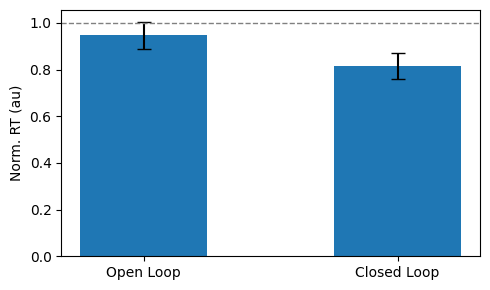

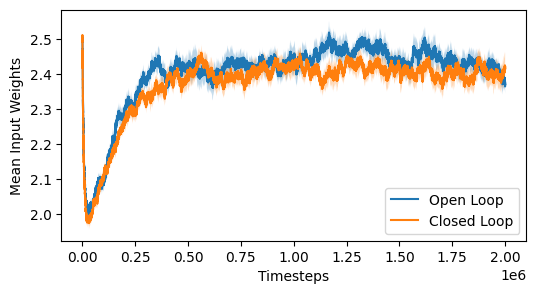

In [550]:
plot_rt_ratio(rt_o3, rt_c)
plot_mean_weights(wo3_mat, wc_mat)

In [551]:
pvals = rt_stat_tests(rt_o3, rt_c)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 0.3869
closed_initial_vs_end       : p = 0.003846


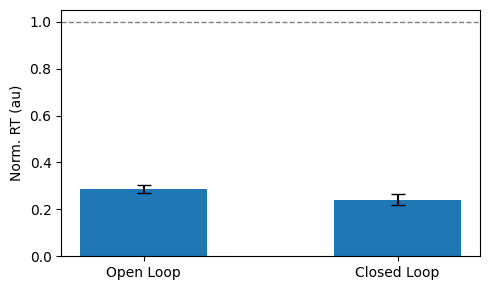

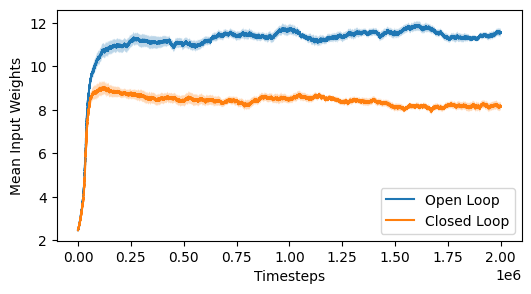

In [552]:
plot_rt_ratio(rt_so3, rt_sc)
plot_mean_weights(wso3_mat, wsc_mat)

In [553]:
pvals = rt_stat_tests(rt_so3, rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 1.773e-19
closed_initial_vs_end       : p = 1.942e-18


In [587]:
# run open-loop simulations in parallel
ols_tasks4 = chain(
    (delayed(run_controlled_open_loop)(net, spk, T)  for net, spk in zip(nets, spk_c)),
    (delayed(run_controlled_open_loop)(snet, spk, T) for snet, spk in zip(snets, spk_sc)),
)
ols_results4 = Parallel(n_jobs=n_cpus)(ols_tasks4)
results_o4, results_so4 = ols_results4[:len(nets)], ols_results4[len(nets):]
spikes_o4, rt_o4, abs_rt_o4, spk_o4, wo4 = zip(*results_o4)
spikes_so4, rt_so4, abs_rt_so4, spk_so4, wso4 = zip(*results_so4)
wo4_mat = np.vstack(wo4)
wso4_mat = np.vstack(wso4)

In [588]:
np.mean([len(spk_c[i]) - len(spk_o4[i]) for i in range(len(nets))])/2000

np.float64(0.0)

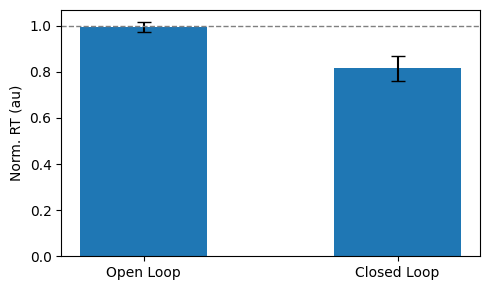

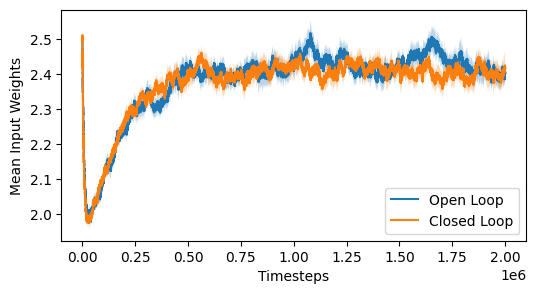

In [589]:
plot_rt_ratio(rt_o4, rt_c)
plot_mean_weights(wo4_mat, wc_mat)

In [590]:
pvals = rt_stat_tests(rt_o4, rt_c)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 0.8668
closed_initial_vs_end       : p = 0.003846


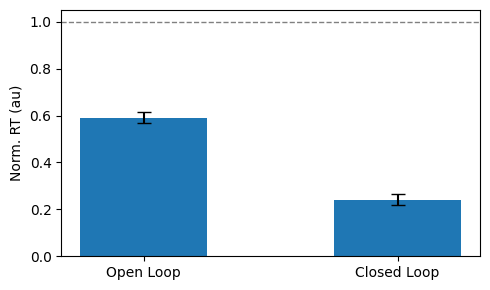

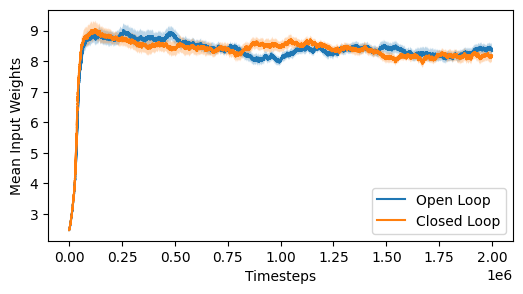

In [591]:
plot_rt_ratio(rt_so4, rt_sc)
plot_mean_weights(wso4_mat, wsc_mat)

In [592]:
pvals = rt_stat_tests(rt_so4, rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 2.769e-13
closed_initial_vs_end       : p = 1.942e-18


## 3. Miscellaneous Runs

### 3.1 Higher Frequency Stimulation

In [14]:
T = 2000*1e3 # 2000s in ms

In [17]:
# varying frequencies (usually higher, locally in time) with random stops; on average 100Hz when firing
# pauses happen at ~0.023Hz
# the pause duration is distributed identically to closed loop: 1000-2000ms
# aggregate spiking statistics should be very similar to long-duration closed loop runs
# rt is calculated block-wise, based on stimulus start
def run_hf_uncontrolled_open_loop(
        net: IzhikevichNetwork, T: float, K: float = 2.0, amp=10.0, on_range=(40000, 44000), off_range=(1000, 2000)
    ):
    dt = net.dt
    steps = int(T / dt)
    block_size = int(10.0 / dt) # 100Hz aggregate firing rate
    p_none, p_sparse = 0.5, 0.3
    mean_w = np.zeros(steps)
    stim_times = []
    rt = []
    abs_rt = []
    spikes = np.zeros((net.N, steps), bool)
    pulse_times = set([0]) # always begin with a stimulus
    net.reset()
    pending_clear_block = 0 # flag

    # helper: fill pulse_times for [start, end) in block_size steps
    def _add_pulses(pulse_times: set, start: int, end: int):
        for b0 in range(start, min(end, steps), block_size):
            r = np.random.rand()
            if r < p_none:
                continue
            elif r < p_none + p_sparse:
                # single stim in block
                pulse_times.add(b0 + np.random.randint(0, block_size))
            else:
                # burst of 2–5 pulses with tight gaps (1-2 ms)
                first = b0 + np.random.randint(0, block_size)
                pulses = [first]
                for _ in range(np.random.randint(2, 6) - 1):
                    gap = np.random.randint(1, 3)
                    nxt = pulses[-1] + gap
                    if nxt < b0 + block_size:
                        pulses.append(nxt)
                    else:
                        break
                pulse_times.update(pulses)

    on_min, on_max = [int(x / dt) for x in on_range]
    off_min, off_max = [int(x / dt) for x in off_range]
    is_on = True
    next_toggle = np.random.randint(on_min, on_max)
    _add_pulses(pulse_times, 0, next_toggle)
    pending = {'t0': 0.0, 'fired': np.zeros(len(net.output_idx), dtype=bool)}
    
    for k in range(steps):
        t = k * dt
        # handle on-off toggle
        if k == next_toggle:
            if is_on: # switch off
                is_on = False
                next_toggle = k + np.random.randint(off_min, off_max)
                pulse_times.clear()
            else: # switch on
                is_on = True
                next_toggle = k + np.random.randint(on_min, on_max)
                _add_pulses(pulse_times, k, next_toggle)
        # stimulate
        stim = np.zeros(net.N)
        if is_on and k in pulse_times:
            stim[net.input_idx] = amp
            stim_times.append(t)
            if pending is None and (k//block_size) > pending_clear_block:
                pending = {'t0': t, 'fired': np.zeros(len(net.output_idx), dtype=bool)}
        fired = net.step(t, stim)
        spikes[:, k] = fired
        mean_w[k] = net.W[net.input_idx, :].mean()
        # get reaction time
        if pending:
            pending['fired'] += fired[net.output_idx]
            if pending['fired'].sum() >= len(net.output_idx)/K:
                    rt.append(t-pending['t0'])
                    abs_rt.append(t)
                    pending_clear_block = k // block_size
                    pending = None
    return spikes, np.array(rt), np.array(abs_rt), np.array(stim_times), mean_w

In [68]:
# run closed-loop simulations in parallel
hf_cls_tasks = chain(
    (delayed(run_closed_loop)(net, T, freq=100)  for net  in nets),
    (delayed(run_closed_loop)(snet, T, freq=100) for snet in snets),
)
hf_cls_results = Parallel(n_jobs=n_cpus)(hf_cls_tasks)
hf_results_c, hf_results_sc = hf_cls_results[:len(nets)], hf_cls_results[len(nets):]
hf_spikes_c, hf_rt_c, hf_abs_rt_c, hf_spk_c, hf_wc = zip(*hf_results_c)
hf_spikes_sc, hf_rt_sc, hf_abs_rt_sc, hf_spk_sc, hf_wsc = zip(*hf_results_sc)
hf_wc_mat = np.vstack(hf_wc)
hf_wsc_mat = np.vstack(hf_wsc)

In [19]:
# run open-loop simulations in parallel
hf_ols_tasks = chain(
    (delayed(run_hf_uncontrolled_open_loop)(net, T)  for net in nets),
    (delayed(run_hf_uncontrolled_open_loop)(snet, T) for snet in snets),
)
hf_ols_results = Parallel(n_jobs=n_cpus)(hf_ols_tasks)
hf_results_o, hf_results_so = hf_ols_results[:len(nets)], hf_ols_results[len(nets):]
hf_spikes_o, hf_rt_o, hf_abs_rt_o, hf_spk_o, hf_wo = zip(*hf_results_o)
hf_spikes_so, hf_rt_so, hf_abs_rt_so, hf_spk_so, hf_wso = zip(*hf_results_so)
hf_wo_mat = np.vstack(hf_wo)
hf_wso_mat = np.vstack(hf_wso)

In [69]:
idx = 0
pauses_c = (np.diff(hf_spk_c[idx]) > 999).sum()/2000 # pause range
pauses_o = (np.diff(hf_spk_o[idx]) > 999).sum()/2000 # off range
print(pauses_c, pauses_o)
print(mean_segment_freq(hf_spk_c[idx]), mean_segment_freq(hf_spk_o[idx]))
on_c,  off_c  = on_off_lengths(hf_spk_c[idx])
on_o,  off_o  = on_off_lengths(hf_spk_o[idx])
print(f"closed-loop   mean on = {on_c:.3f}s   mean off = {off_c:.3f}s")
print(f"open-loop     mean on = {on_o:.3f}s   mean off = {off_o:.3f}s")

0.02 0.023
100.0 85.08175965604393
closed-loop   mean on = 47.428s   mean off = 1.386s
open-loop     mean on = 41.127s   mean off = 1.457s


In [70]:
# the frequency deficit can arise from the premature clearing of pulses upon toggle
# otherwise, over an uninterrupted block of time, this will be proper
np.mean([len(hf_spk_c[i]) - len(hf_spk_o[i]) for i in range(len(nets))])/2000

np.float64(14.479575)

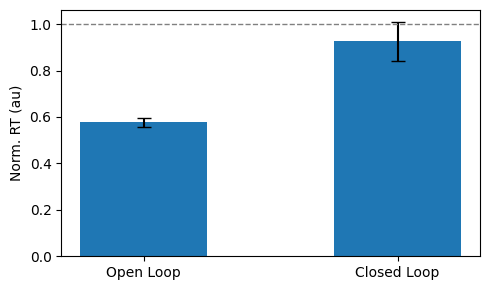

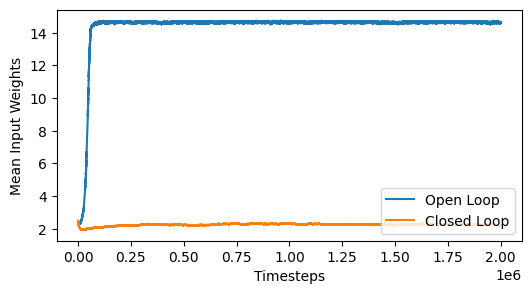

In [71]:
plot_rt_ratio(hf_rt_o, hf_rt_c, window=10) # low number of recorded rt_c (~40 tot)
plot_mean_weights(hf_wo_mat, hf_wc_mat)

In [72]:
pvals = rt_stat_tests(hf_rt_o, hf_rt_c, window=10)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 1.326e-14
closed_initial_vs_end       : p = 0.4022


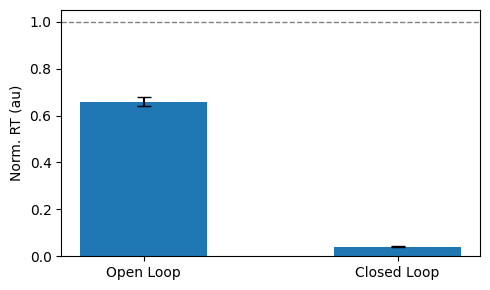

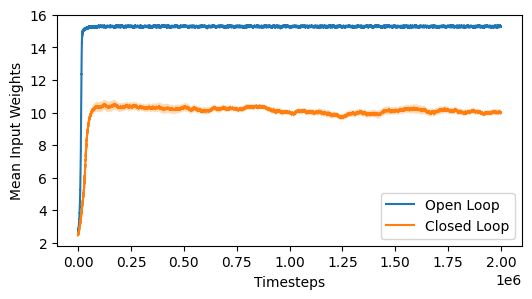

In [73]:
plot_rt_ratio(hf_rt_so, hf_rt_sc)
plot_mean_weights(hf_wso_mat, hf_wsc_mat)

In [74]:
pvals = rt_stat_tests(hf_rt_so, hf_rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 2.509e-13
closed_initial_vs_end       : p = 2.133e-42


In [45]:
# run open-loop simulations in parallel
hf_ols_tasks1 = chain(
    (
        delayed(run_periodic_open_loop)(
        net, T, freq=100, on_range=(40000, 44000), off_range=(1000, 2000)
        )  for net in nets
    ),
    (
        delayed(run_periodic_open_loop)(
            snet, T, freq=100, on_range=(40000, 44000), off_range=(1000, 2000)
        ) for snet in snets
    ),
)
hf_ols_results1 = Parallel(n_jobs=n_cpus)(hf_ols_tasks1)
hf_results_o1, hf_results_so1 = hf_ols_results1[:len(nets)], hf_ols_results1[len(nets):]
hf_spikes_o1, hf_rt_o1, hf_abs_rt_o1, hf_spk_o1, hf_wo1 = zip(*hf_results_o1)
hf_spikes_so1, hf_rt_so1, hf_abs_rt_so1, hf_spk_so1, hf_wso1 = zip(*hf_results_so1)
hf_wo1_mat = np.vstack(hf_wo1)
hf_wso1_mat = np.vstack(hf_wso1)

In [75]:
co1 = np.mean([len(hf_spk_c[i]) - len(hf_spk_o1[i]) for i in range(len(nets))])/2000
oo1 = np.mean([len(hf_spk_o[i]) - len(hf_spk_o1[i]) for i in range(len(nets))])/2000
print(co1, oo1)

0.04205 -14.437524999999999


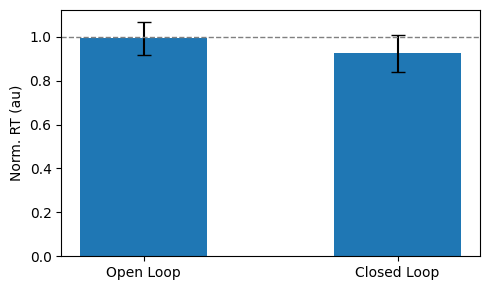

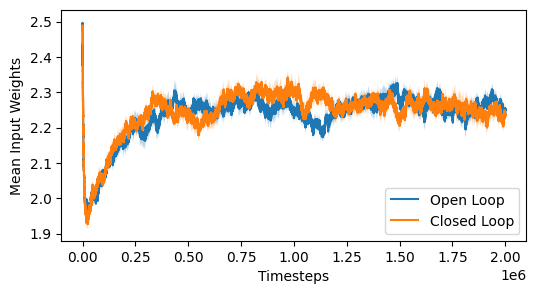

In [76]:
plot_rt_ratio(hf_rt_o1, hf_rt_c, window=10) # low number of recorded rt_c (~40 tot)
plot_mean_weights(hf_wo1_mat, hf_wc_mat)

In [77]:
pvals = rt_stat_tests(hf_rt_o1, hf_rt_c, window=10)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 0.9318
closed_initial_vs_end       : p = 0.4022


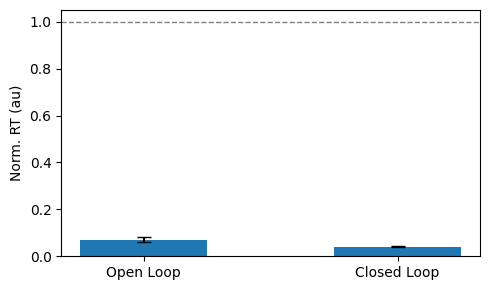

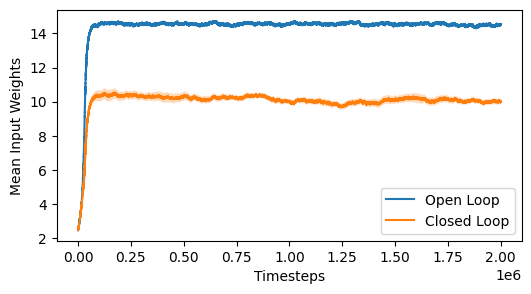

In [78]:
plot_rt_ratio(hf_rt_so1, hf_rt_sc)
plot_mean_weights(hf_wso1_mat, hf_wsc_mat)

In [79]:
pvals = rt_stat_tests(hf_rt_so1, hf_rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 4.925e-27
closed_initial_vs_end       : p = 2.133e-42


In [80]:
# run open-loop simulations in parallel
hf_ols_tasks2 = chain(
    (delayed(run_controlled_open_loop)(net, spk, T, min_sep=9)  for net, spk in zip(nets, hf_spk_c)),
    (delayed(run_controlled_open_loop)(snet, spk, T, min_sep=9) for snet, spk in zip(snets, hf_spk_sc)),
)
hf_ols_results2 = Parallel(n_jobs=n_cpus)(hf_ols_tasks2)
hf_results_o2, hf_results_so2 = hf_ols_results2[:len(nets)], hf_ols_results2[len(nets):]
hf_spikes_o2, hf_rt_o2, hf_abs_rt_o2, hf_spk_o2, hf_wo2 = zip(*hf_results_o2)
hf_spikes_so2, hf_rt_so2, hf_abs_rt_so2, hf_spk_so2, hf_wso2 = zip(*hf_results_so2)
hf_wo2_mat = np.vstack(hf_wo2)
hf_wso2_mat = np.vstack(hf_wso2)

In [81]:
np.mean([len(hf_spk_c[i]) - len(hf_spk_o2[i]) for i in range(len(nets))])/2000

np.float64(0.0)

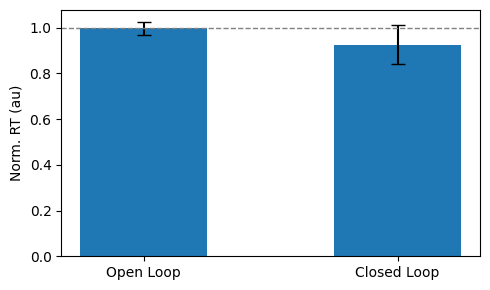

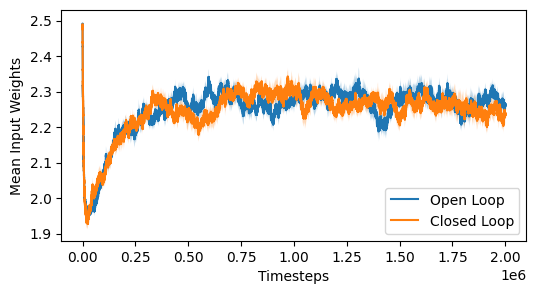

In [87]:
plot_rt_ratio(hf_rt_o2, hf_rt_c, window=10) # low number of recorded rt_c (~40 tot)
plot_mean_weights(hf_wo2_mat, hf_wc_mat)

In [83]:
pvals = rt_stat_tests(hf_rt_o2, hf_rt_c, window=10)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 0.9182
closed_initial_vs_end       : p = 0.4022


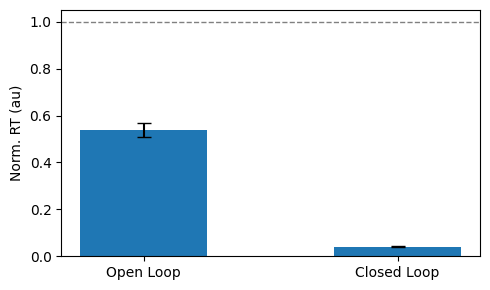

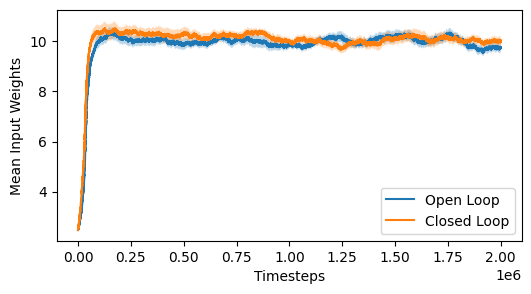

In [84]:
plot_rt_ratio(hf_rt_so2, hf_rt_sc)
plot_mean_weights(hf_wso2_mat, hf_wsc_mat)

In [85]:
pvals = rt_stat_tests(hf_rt_so2, hf_rt_sc)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

open_initial_vs_end         : p = 3.423e-12
closed_initial_vs_end       : p = 2.133e-42


### 3.2 Beyond Stimulus Avoidance

#### 3.2.1 Supporting Functions

In [95]:
# "positive" feedback scheme, with increase in stimulation amplitude or freq upon output firing
def run_posfb_closed_loop(net: IzhikevichNetwork, T: float, K: float = 2.0, freq=20.0, 
                          amp=10.0, pos_mode=None, pos_range=(500, 501)):
    dt = net.dt
    steps = int(T / dt)
    spikes = np.zeros((net.N, steps), dtype=bool)
    mean_w = np.zeros(steps)
    period_steps = int((1000.0/freq)/dt)
    period_ms = 1000.0/freq
    pos_min, pos_max = [int(x/dt) for x in pos_range]
    net.reset()
    abs_rt = []
    rt = []
    stim_times = []
    next_pos = 0
    next_pulse = 0
    pending = None
    for k in range(steps):
        t = k * dt
        stim = np.zeros(net.N)
        if next_pos is not None and k < next_pos:
            if k >= next_pulse:
                if pos_mode == 'freq':
                    # double frequency, same amplitude
                    pos_period_steps = int((1000.0/(freq*2))/dt)
                    next_pulse = k + pos_period_steps
                    stim[net.input_idx] = amp
                elif pos_mode == 'amp':
                    # same period, double amplitude
                    next_pulse = k + period_steps
                    stim[net.input_idx] = amp * 2
                else:
                    # fallback to baseline if no pos_mode
                    next_pulse = k + period_steps
                    stim[net.input_idx] = amp
                stim_times.append(t)
            pending = None
        else:
            if next_pos is not None and k >= next_pos:
                next_pos = None
                pending = {'t0': t, 'fired': np.zeros(
                    len(net.output_idx), dtype=bool)}
                next_pulse = k
            if next_pos is None and k >= next_pulse:
                if pending is not None:
                    pending['fired'] = np.zeros(
                        len(net.output_idx), dtype=bool)
                    pending['end'] = t + period_ms
                next_pulse = k + period_steps
                stim[net.input_idx] = amp
                stim_times.append(t)
        fired = net.step(t, stim)
        spikes[:, k] = fired
        mean_w[k] = net.W[net.input_idx, :].mean()
        if pending:
            if t < pending['end']:
                pending['fired'] += fired[net.output_idx]
                if pending['fired'].sum() >= len(net.output_idx)/K:
                    rt.append(t - pending['t0'])
                    abs_rt.append(t)
                    pos = np.random.randint(pos_min, pos_max)
                    next_pos = k + pos
                    next_pulse = k
                    pending = None
            else:
                rt.append(np.nan)
                abs_rt.append(np.nan)
                pending = None
    return spikes, np.array(rt), np.array(abs_rt), np.array(stim_times), mean_w

In [17]:
def plot_rt_ratio(rt_a, rt_f, window=20, variation=5, labels=[None, None]):
    if not isinstance(rt_a, (list, tuple)):
        rt_a = [rt_a]
    if not isinstance(rt_f, (list, tuple)):
        rt_f = [rt_f]
    assert len(rt_a) == len(rt_f) # must have same number of runs
    M = len(rt_a)
    
    mu_a = mu_f = err_a = err_f = None
    if M > 1:
        # compute one ratio per run
        ratios_a = np.array([np.nanmean(a[-window:]) / np.nanmean(a[:window]) for a in rt_a])
        ratios_f = np.array([np.nanmean(f[-window:]) / np.nanmean(f[:window]) for f in rt_f])
        # mean ± sem
        mu_a, mu_f = ratios_a.mean(), ratios_f.mean()
        err_a = ratios_a.std() / np.sqrt(M)
        err_f = ratios_f.std() / np.sqrt(M)
    else:
        # single run: sweep window for robustness
        a0 = rt_a[0]
        f0 = rt_f[0]
        # build varied window sizes
        ws = np.arange(max(1, window-variation), window+variation+1)
        # ratios across varied windows
        ra = np.array([np.nanmean(a0[-w:]) / np.nanmean(a0[:w]) for w in ws])
        rf = np.array([np.nanmean(f0[-w:]) / np.nanmean(f0[:w]) for w in ws])
        mu_a, mu_f = ra.mean(), rf.mean()
        # error‐bars = sd of those ratios
        err_a, err_f = ra.std(), rf.std()

    # plotting
    if labels == [None, None]:
        labels = ['Amp. Mode', 'Freq. Mode']
    x = np.arange(2)
    width = 0.5
    plt.figure(figsize=(5, 3))
    plt.bar(x, [mu_a, mu_f], width, yerr=[err_a, err_f], capsize=5)
    plt.xticks(x, labels)
    plt.ylabel('Norm. RT (au)')
    plt.axhline(1, color='gray', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

In [32]:
def compare_mean_weights(wamp, wfreq, labels=[None, None]):
    arr_wa = np.atleast_2d(wamp)
    arr_wf = np.atleast_2d(wfreq)
    M, T = arr_wa.shape
    if labels == [None, None]:
        labels = ['Amp. Mode', 'Freq. Mode']

    # mean over nets
    mu_wa = np.nanmean(arr_wa, axis=0)
    mu_wf = np.nanmean(arr_wf, axis=0)

    plt.figure(figsize=(6, 3))
    if M > 1:
        # sem ribbons
        sem_wa = np.nanstd(arr_wa, axis=0) / np.sqrt(M)
        sem_wf = np.nanstd(arr_wf, axis=0) / np.sqrt(M)
        t = np.arange(T)

        plt.plot(t, mu_wa, label=labels[0])
        plt.fill_between(t, mu_wa - sem_wa, mu_wa + sem_wa, alpha=0.3)

        plt.plot(t, mu_wf, label=labels[1])
        plt.fill_between(t, mu_wf - sem_wf, mu_wf + sem_wf, alpha=0.3)
    else:
        # single‐net simply plot
        t = np.arange(T)
        plt.plot(t, mu_wa, label=labels[0])
        plt.plot(t, mu_wf, label=labels[1])

    plt.xlabel('Timesteps')
    plt.ylabel('Mean Input Weights')
    plt.legend(loc='upper right')
    plt.show()

In [21]:
# one-sampled t-test (or rank test) for initial-end ratios
def rt_stat_tests(rt_a, rt_f, window=20, variation=5, nonparametric=False, labels=[None, None]):
    if not isinstance(rt_a, (list, tuple)):
        rt_a = [rt_a]
    if not isinstance(rt_f, (list, tuple)):
        rt_f = [rt_f]
    assert len(rt_a) == len(rt_f) # must have same number of runs
    M = len(rt_a)
    if labels == [None, None]:
        labels = ['Amp. Mode', 'Freq. Mode']

    if M > 1:
        # compute one ratio per run
        ratios_a = np.array([np.nanmean(a[-window:]) / np.nanmean(a[:window]) for a in rt_a])
        ratios_f = np.array([np.nanmean(f[-window:]) / np.nanmean(f[:window]) for f in rt_f])
    else:
        # single run: sweep window for robustness
        a0 = rt_a[0]
        f0 = rt_f[0]
        # build varied window sizes
        ws = np.arange(max(1, window-variation), window+variation+1)
        # ratios across varied windows
        ratios_a = np.array([np.nanmean(a0[-w:]) / np.nanmean(a0[:w]) for w in ws])
        ratios_f = np.array([np.nanmean(f0[-w:]) / np.nanmean(f0[:w]) for w in ws])

    results = {}
    if nonparametric:
        # wilcoxon signed‐rank: test median difference vs 0
        _, p_a = stats.wilcoxon(ratios_a - 1, alternative='two-sided', zero_method='wilcox')
        _, p_f = stats.wilcoxon(ratios_f - 1, alternative='two-sided', zero_method='wilcox')
    else:
        # one‐sample t‐test vs popmean = 1
        _, p_a = stats.ttest_1samp(ratios_a, popmean=1, nan_policy='omit')
        _, p_f = stats.ttest_1samp(ratios_f, popmean=1, nan_policy='omit')
    results[labels[0]+'_initial_vs_end'] = p_a
    results[labels[1]+'_initial_vs_end'] = p_f
    return results

#### 3.2.2 Closed Loop Runs

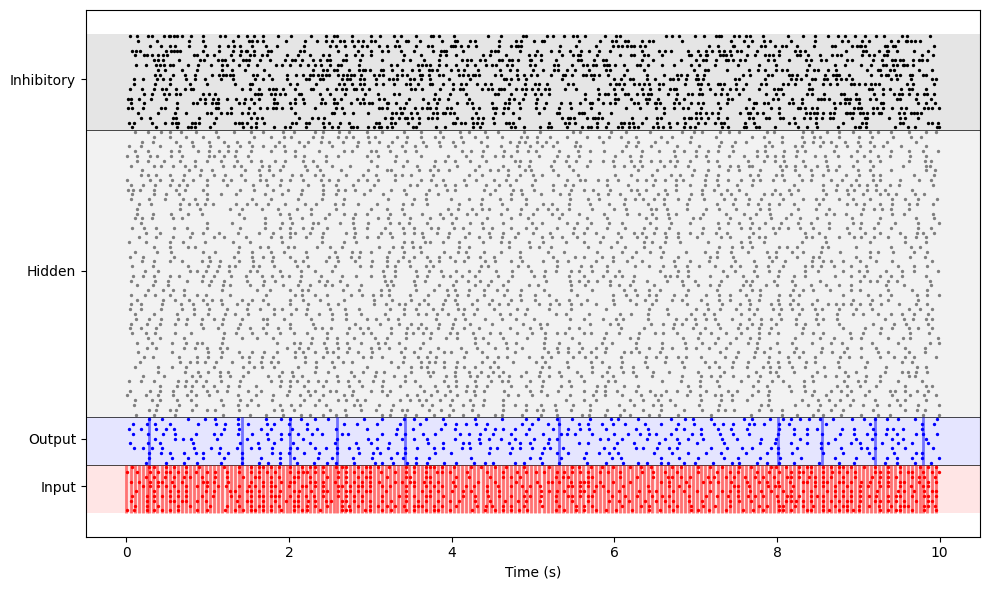

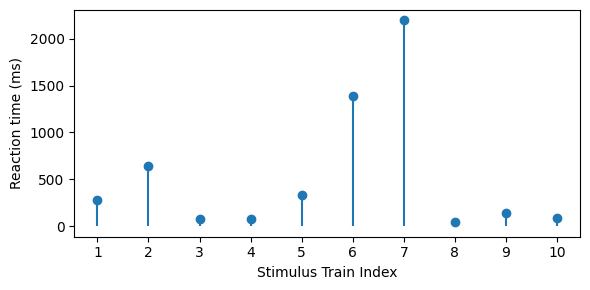

In [15]:
spikes_c, rt_c, abs_rt_c, spk_c, wc = run_posfb_closed_loop(net, 10000, pos_mode='amp')
net.plot_raster(spikes_c, reaction_times=abs_rt_c, stim_times=spk_c)
plot_reaction_times(rt_c)

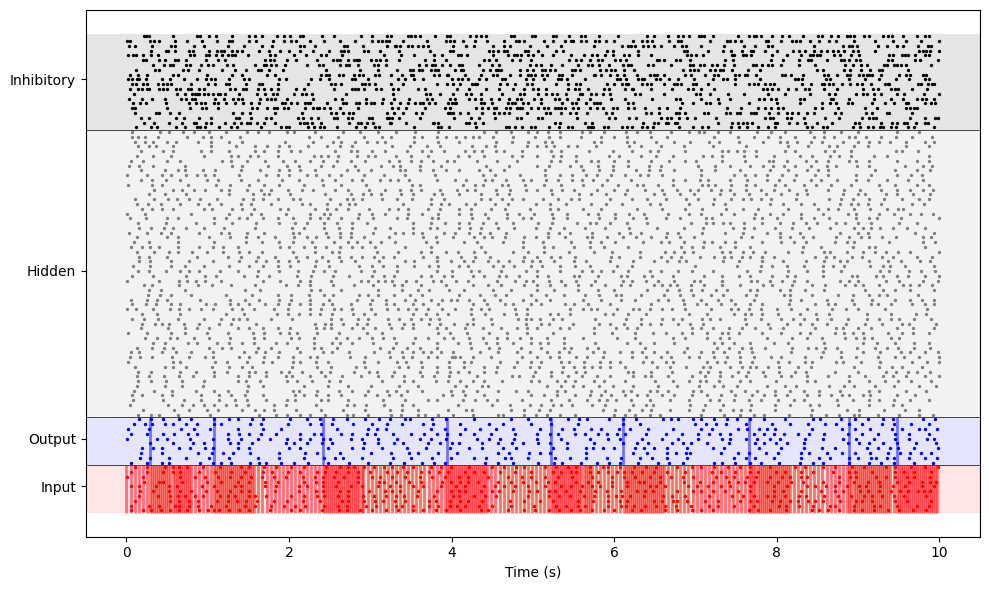

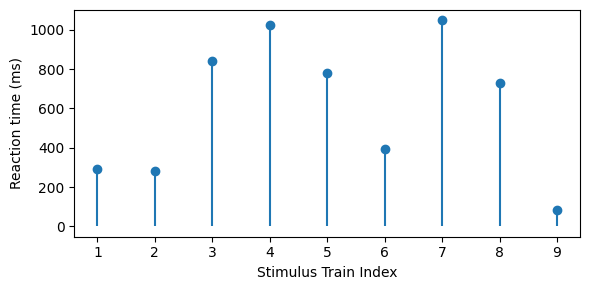

In [16]:
spikes_c, rt_c, abs_rt_c, spk_c, wc = run_posfb_closed_loop(net, 10000, pos_mode='freq')
net.plot_raster(spikes_c, reaction_times=abs_rt_c, stim_times=spk_c)
plot_reaction_times(rt_c)

In [34]:
T = 1250*1e3 # 1250s in ms

In [41]:
# run closed-loop simulations in parallel (fixed feedback duration)
cnets = [deepcopy(net) for net in nets]
posfb_cls_tasks = chain(
    (delayed(run_posfb_closed_loop)(net, T, pos_mode='amp', pos_range=(1000,1001)) for net in nets),
    (delayed(run_posfb_closed_loop)(net, T, pos_mode='freq', pos_range=(1000,1001)) for net in cnets),
)
posfb_cls_results = Parallel(n_jobs=n_cpus)(posfb_cls_tasks)
posfb_amp_results, posfb_freq_results = posfb_cls_results[:len(nets)], posfb_cls_results[len(nets):]
posfb_amp_spikes, posfb_amp_rt, posfb_amp_abs_rt, posfb_amp_spk, posfb_amp_w = zip(*posfb_amp_results)
posfb_freq_spikes, posfb_freq_rt, posfb_freq_abs_rt, posfb_freq_spk, posfb_freq_w = zip(*posfb_freq_results)
posfb_amp_w_mat = np.vstack(posfb_amp_w)
posfb_freq_w_mat = np.vstack(posfb_freq_w)

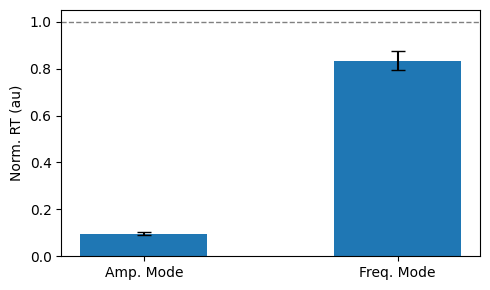

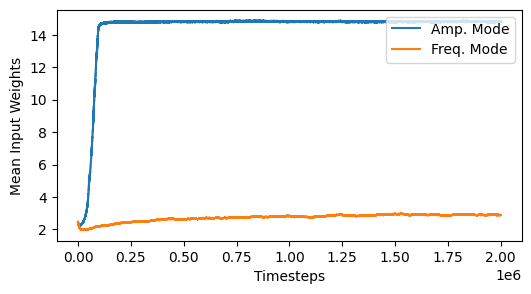

Amp. Mode_initial_vs_end    : p = 1.876e-30
Freq. Mode_initial_vs_end   : p = 0.0009009


In [42]:
plot_rt_ratio(posfb_amp_rt, posfb_freq_rt)
compare_mean_weights(posfb_amp_w_mat, posfb_freq_w_mat)
pvals = rt_stat_tests(posfb_amp_rt, posfb_freq_rt)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

In [37]:
# run closed-loop simulations in parallel (variable feedback duration)
posfb_cls_tasks = chain(
    (delayed(run_posfb_closed_loop)(net, T, pos_mode='amp', pos_range=(1000,2000)) for net in nets),
    (delayed(run_posfb_closed_loop)(net, T, pos_mode='freq', pos_range=(1000,2000)) for net in cnets),
)
posfb_cls_results = Parallel(n_jobs=n_cpus)(posfb_cls_tasks)
posfb_amp_results, posfb_freq_results = posfb_cls_results[:len(nets)], posfb_cls_results[len(nets):]
posfb_amp_spikes, posfb_amp_rt, posfb_amp_abs_rt, posfb_amp_spk, posfb_amp_w = zip(*posfb_amp_results)
posfb_freq_spikes, posfb_freq_rt, posfb_freq_abs_rt, posfb_freq_spk, posfb_freq_w = zip(*posfb_freq_results)
posfb_amp_w_mat = np.vstack(posfb_amp_w)
posfb_freq_w_mat = np.vstack(posfb_freq_w)

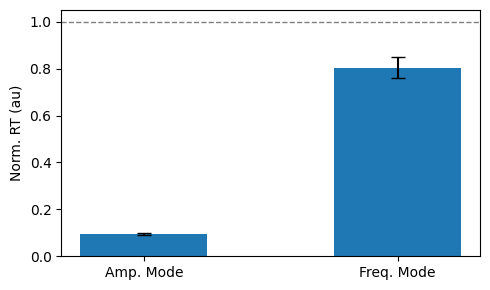

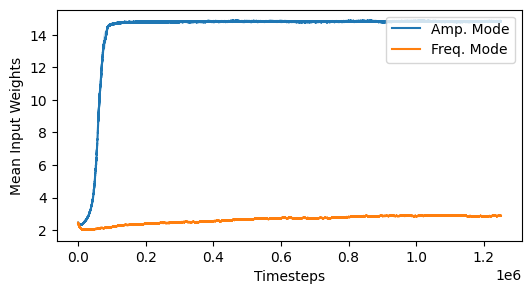

Amp. Mode_initial_vs_end    : p = 5.069e-33
Freq. Mode_initial_vs_end   : p = 0.0005629


In [38]:
plot_rt_ratio(posfb_amp_rt, posfb_freq_rt)
compare_mean_weights(posfb_amp_w_mat, posfb_freq_w_mat)
pvals = rt_stat_tests(posfb_amp_rt, posfb_freq_rt)
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

In [ ]:
# control condition: perceptibly no feedback
T = 2000*1e3 # 2000s in ms
ctrl_cls_tasks = chain(
    (delayed(run_posfb_closed_loop)(net, T, pos_mode=None, freq=20) for net in nets),
    (delayed(run_posfb_closed_loop)(net, T, pos_mode=None, freq=30) for net in cnets),
)
ctrl_cls_results = Parallel(n_jobs=n_cpus)(ctrl_cls_tasks)
ctrl_20hz_results, ctrl_30hz_results = ctrl_cls_results[:len(nets)], ctrl_cls_results[len(nets):]
ctrl_20hz_spikes, ctrl_20hz_rt, ctrl_20hz_abs_rt, ctrl_20hz_spk, ctrl_20hz_w = zip(*ctrl_20hz_results)
ctrl_30hz_spikes, ctrl_30hz_rt, ctrl_30hz_abs_rt, ctrl_30hz_spk, ctrl_30hz_w = zip(*ctrl_30hz_results)
ctrl_20hz_w_mat = np.vstack(ctrl_20hz_w)
ctrl_30hz_w_mat = np.vstack(ctrl_30hz_w)

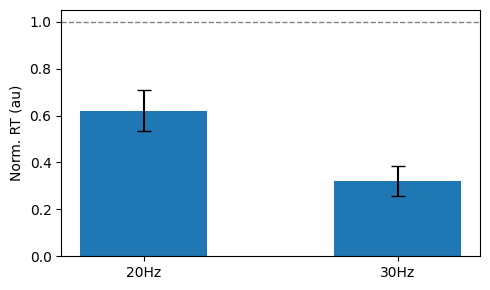

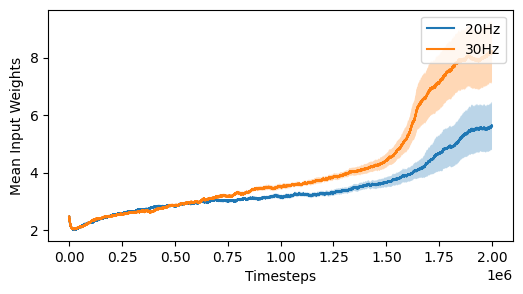

20Hz_initial_vs_end         : p = 0.0004225
30Hz_initial_vs_end         : p = 4.013e-09


In [40]:
plot_rt_ratio(ctrl_20hz_rt, ctrl_30hz_rt, labels=['20Hz', '30Hz'])
compare_mean_weights(ctrl_20hz_w_mat, ctrl_30hz_w_mat, labels=['20Hz', '30Hz'])
pvals = rt_stat_tests(ctrl_20hz_rt, ctrl_30hz_rt, labels=['20Hz', '30Hz'])
for k, v in pvals.items():
    print(f"{k:28s}: p = {v:.4g}")

### 3.3 Quantifying Stimulus Irregularity

In [ ]:
def stim_irregularity(stim_times, T_ms, win_ms=1_000):
    """
    metrics : dict {
        'rate'       : mean stimulus rate (Hz),
        'cv'         : global coefficient of ISI variation,
        'lv'         : local variation (Shinomoto 2003),
        'burstiness' : (σ−μ)/(σ+μ) of ISIs (Goh-Barabási 2008),
        'fano'       : Fano factor of counts in win_ms bins
    }
    """
    st = np.asarray(stim_times, dtype=float)
    if st.size < 3:
        raise ValueError("Need at least three stimuli to measure irregularity.")
    isi = np.diff(st)
    mu, sigma = isi.mean(), isi.std()
    cv  = sigma / mu
    lv  = 3.0 * np.mean(((isi[1:] - isi[:-1])**2) /
                        ((isi[1:] + isi[:-1])**2)) # step-by-step jitter
    burstiness = (sigma - mu) / (sigma + mu)
    n_bins = int(np.ceil(T_ms / win_ms))
    edges  = np.arange(n_bins + 1) * win_ms
    counts = np.histogram(st, edges)[0]
    fano   = counts.var() / counts.mean() if counts.mean() > 0 else np.nan
    rate = 1000 * st.size / T_ms # Hz
    return dict(rate=rate, cv=cv, lv=lv, burstiness=burstiness, fano=fano)

In [101]:
T = 2000*1e3  # 2000 seconds in ms
_, _, _, spk_cls, wcls = run_closed_loop(net, T)
_, _, _, spk_ols_unctrl, wols_unctrl = run_uncontrolled_open_loop(net, T)
_, _, _, spk_ols_unctrl_long, wols_unctrl_long = run_uncontrolled_open_loop(net, T, on_range=(750,1250))
_, _, _, spk_ols_period, wols_period = run_periodic_open_loop(net, T, on_range=(400, 600), off_range=(1000, 2000))
_, _, _, spk_ols_ctrl, wols_ctrl = run_controlled_open_loop(net, spk_cls, T)
_, _, _, spk_cls_hf, wcls_hf = run_closed_loop(net, T, freq=100)
_, _, _, spk_ols_unctrl_hf, wols_unctrl_hf = run_hf_uncontrolled_open_loop(net, T)
_, _, _, spk_ols_period_hf, wols_period_hf = run_periodic_open_loop(net, T, freq=100, on_range=(40000, 44000), 
                                                                    off_range=(1000, 2000))
_, _, _, spk_ols_ctrl_hf, wols_ctrl_hf = run_controlled_open_loop(net, spk_cls_hf, T, min_sep=9)
_, _, _, spk_cls_posampfb, wcls_posampfb = run_posfb_closed_loop(net, T, pos_mode='amp', pos_range=(1000,2000))
_, _, _, spk_cls_posfreqfb, wcls_posfreqfb = run_posfb_closed_loop(net, T, pos_mode='freq', pos_range=(1000,2000))
_, _, _, spk_cls_contspk, wcls_contspk = run_posfb_closed_loop(net, T, pos_mode=None, freq=25) # ~open-loop (jitter)

In [108]:
_, _, _, spk_cls_posfreqfb, wcls_posfreqfb = run_posfb_closed_loop(net, T, pos_mode='freq', pos_range=(1000,2000))

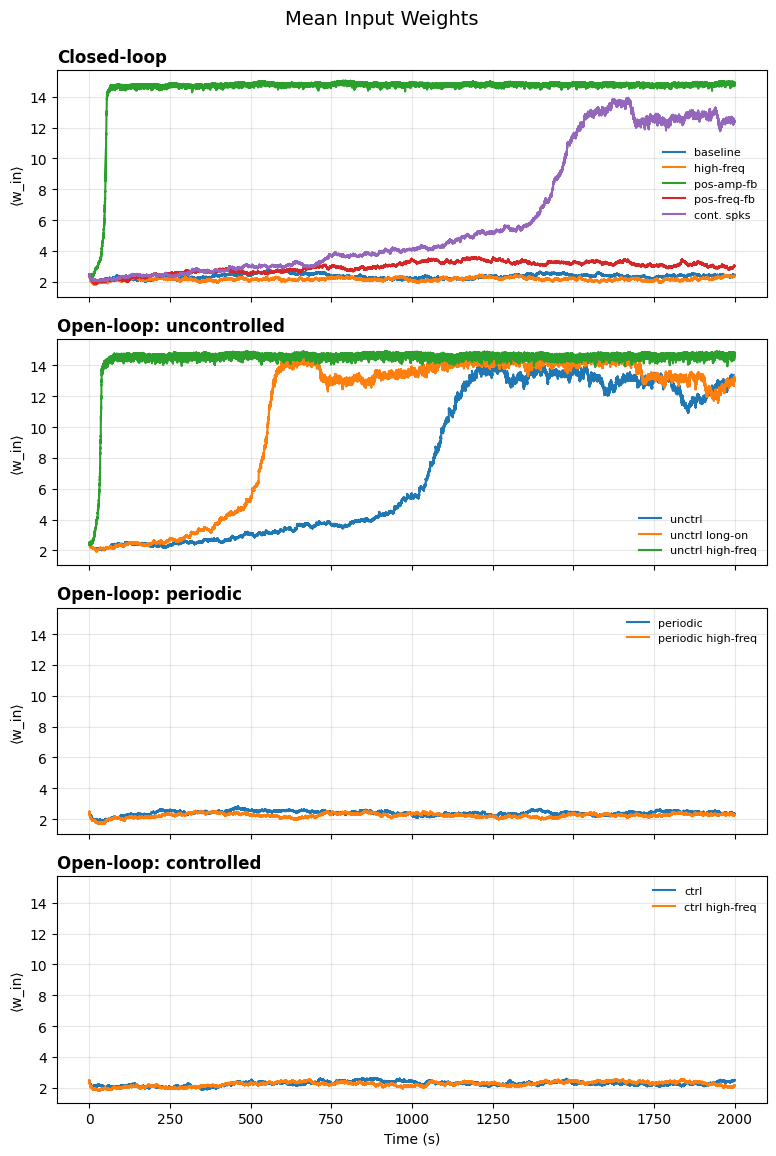

In [112]:
def plot_weight_evolution(groups, T_ms, title="Mean Input Weights"):
    uniq_groups = [g for g, *_ in groups]
    row_breaks  = np.flatnonzero(np.r_[True, np.diff([hash(g) for g in uniq_groups])])
    n_rows      = len(row_breaks)
    fig, axs = plt.subplots(n_rows, 1, figsize=(8, 3 * n_rows), sharex=True, sharey=True)
    if n_rows == 1:
        axs = [axs]
    row_idx = -1
    curr_grp = None
    for (grp, label, w_trace) in groups:
        if grp != curr_grp:
            row_idx += 1
            curr_grp = grp
            axs[row_idx].set_title(grp, loc="left", fontweight="bold")
        w = np.asarray(w_trace, dtype=float)
        t = np.linspace(0, T_ms / 1000.0, len(w))
        axs[row_idx].plot(t, w, label=label)
    for ax in axs:
        ax.grid(alpha=0.3)
        ax.set_ylabel("⟨w_in⟩")
        ax.legend(fontsize=8, frameon=False)
    axs[-1].set_xlabel("Time (s)")
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.suptitle(title, fontsize=14, y=0.96)
    plt.show()

weight_groups = [
    # ---------- closed-loop stimulation ----------
    ("Closed-loop",            "baseline",           wcls),
    ("Closed-loop",            "high-freq",          wcls_hf),
    ("Closed-loop",            "pos-amp-fb",         wcls_posampfb),
    ("Closed-loop",            "pos-freq-fb",        wcls_posfreqfb),
    ("Closed-loop",            "cont. spks",         wcls_contspk),

    # ---------- open-loop : uncontrolled ----------
    ("Open-loop: uncontrolled",     "unctrl",              wols_unctrl),
    ("Open-loop: uncontrolled",     "unctrl long-on",      wols_unctrl_long),
    ("Open-loop: uncontrolled",     "unctrl high-freq",    wols_unctrl_hf),

    # ---------- open-loop : periodic ----------
    ("Open-loop: periodic",   "periodic",            wols_period),
    ("Open-loop: periodic",   "periodic high-freq",  wols_period_hf),

    # ---------- open-loop : controlled ----------
    ("Open-loop: controlled", "ctrl",                wols_ctrl),
    ("Open-loop: controlled", "ctrl high-freq",      wols_ctrl_hf),
]
plot_weight_evolution(weight_groups, T)

In [113]:
conditions = [
    # ---------- closed-loop stimulation ----------
    ("Closed-loop",            "baseline",           spk_cls),
    ("Closed-loop",            "high-freq",          spk_cls_hf),
    ("Closed-loop",            "pos-amp-fb",         spk_cls_posampfb),
    ("Closed-loop",            "pos-freq-fb",        spk_cls_posfreqfb),
    ("Closed-loop",            "cont. spks",         spk_cls_contspk),

    # ---------- open-loop : uncontrolled ----------
    ("Open-loop: uncontrolled",     "unctrl",              spk_ols_unctrl),
    ("Open-loop: uncontrolled",     "unctrl long-on",      spk_ols_unctrl_long),
    ("Open-loop: uncontrolled",     "unctrl high-freq",    spk_ols_unctrl_hf),

    # ---------- open-loop : periodic ----------
    ("Open-loop: periodic",   "periodic",            spk_ols_period),
    ("Open-loop: periodic",   "periodic high-freq",  spk_ols_period_hf),

    # ---------- open-loop : controlled ----------
    ("Open-loop: controlled", "ctrl",                spk_ols_ctrl),
    ("Open-loop: controlled", "ctrl high-freq",      spk_ols_ctrl_hf),
]
results = []
for grp, label, stim in conditions:
    m = stim_irregularity(stim, T)
    results.append((grp, label, m))
col_hdr = "Condition                 rate(Hz)   CV     LV     B      Fano"
line    = "-" * len(col_hdr)
current_grp = None
print(col_hdr)
print(line)
for grp, label, m in results:
    if grp != current_grp:
        if current_grp is not None:
            print()
        print(f"[{grp}]")
        current_grp = grp
    print(f"  {label:<22} {m['rate']:7.1f}  {m['cv']:5.2f}  "
          f"{m['lv']:5.2f}  {m['burstiness']:5.2f}  {m['fano']:6.2f}")

Condition                 rate(Hz)   CV     LV     B      Fano
--------------------------------------------------------------
[Closed-loop]
  baseline                   5.0   2.29   0.48   0.39    6.16
  high-freq                 96.7   2.25   0.00   0.38    2.62
  pos-amp-fb                20.7   0.15   0.08  -0.73    0.02
  pos-freq-fb               35.5   0.31   0.03  -0.53    0.82
  cont. spks                26.0   0.15   0.06  -0.74    0.03

[Open-loop: uncontrolled]
  unctrl                     4.7   2.37   1.56   0.41    5.01
  unctrl long-on             7.6   2.84   1.43   0.48    7.26
  unctrl high-freq          81.9   2.42   1.01   0.42    3.88

[Open-loop: periodic]
  periodic                   5.3   2.32   0.50   0.40    3.53
  periodic high-freq        96.6   2.20   0.00   0.37    2.61

[Open-loop: controlled]
  ctrl                       5.0   0.75   0.48  -0.14    0.59
  ctrl high-freq            96.7   0.07   0.01  -0.88    0.01


We can conclude from the above, that the mean input weights diverging (ramping up) from the baseline is a robust signature for the network shifting into a burst regime. This happens either when there is high local irregularity, high intensity, or prolonged duration of the stimulus. The more regular stimuli do not cause such divergence and the network stays stable in both closed and open loop.